In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep

Converting orders, items and states into an order_facts table for summarization.

There are some very minor inconsistencies between these three tables. 
Mostly this appears to be related to database timing, such as missing state updates on 2019-03-24/25 or items with no corresponding order w/ timestamps on 2018-01-01.
Outside these end-points there are a few small discrepancies. For the purposes of this exercise I didn't worry about them, overall counts are small.

In [78]:
## ORDERS
orders = pd.read_csv('data/bl_fulfillment_orders.csv')
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['created_dt'] = orders['created_at'].dt.floor('d') # date
orders['created_mt'] = orders['created_at'].dt.to_period('M') # month
orders['anon_user'] = np.isnan(orders.user_id)

## ITEMS
items = pd.read_csv('data/bl_fulfillment_order_items.csv')
items['created_at'] = pd.to_datetime(items['created_at'])
items['created_dt'] = items['created_at'].dt.floor('d')
items['created_mt'] = items['created_at'].dt.to_period('M')

## Sales Lines & Items of Interest
## In practice I'd want to formally code item categories as part of a 
## a product table, not by string-matching or inferring via by missing field logic, etc. :)
## But for the purposes of expediency I'll do this for now.
# Baby Boxes
items['baby_box'] = items.name.str.contains('Babylist Hello Baby Box')
items['fund'] = np.isnan(items.product_id)
# Bottles excluding Bottle accessories
items['bottle'] = items.name.str.contains('Bottle') &\
                    np.logical_not(items.name.str.contains('Bottle Warmer')) &\
                    np.logical_not(items.name.str.contains('Bottle Brush')) &\
                    np.logical_not(items.name.str.contains('Bottle Washer')) &\
                    np.logical_not(items.name.str.contains('Bottle Mixer')) &\
                    np.logical_not(items.name.str.contains('Bottle Cooler')) &\
                    np.logical_not(items.name.str.contains('Bottle Drying'))&\
                    np.logical_not(items.name.str.contains('Bottle Sterilization'))&\
                    np.logical_not(items.name.str.contains('Tot Bottle and Cup Cleaning Set'))
# Babylist Store Gift Cards
items['gift_card'] = items.name.str.contains('Babylist Store Gift Card')
items['gift_card_value'] = items.gift_card * items.price

## STATES
states = pd.read_csv('data/bl_fulfillment_order_states.csv')
states['created_at'] = pd.to_datetime(states['created_at'])
states['created_dt'] = states['created_at'].dt.floor('d')
states['created_mt'] = states['created_at'].dt.to_period('M')
states['created_wk'] = states['created_at'].dt.to_period('W').dt.start_time
states['state_number_asc'] = states.sort_values(['created_at'], ascending=True) \
                     .groupby(['order_id']) \
                     .cumcount() + 1
states['state_number_desc'] = states.sort_values(['created_at'], ascending=False) \
                     .groupby(['order_id']) \
                     .cumcount() + 1
states['payment_hold'] = states.state.str.contains('payment hold')
states['fraud_hold'] = states.state.str.contains('fraud hold')
states['operator_hold'] = states.state.str.contains('operator hold')

In [79]:
## order item features
special_items = items[['order_id', 'baby_box', 'fund', 'gift_card', 'bottle']]\
    .groupby('order_id')\
    .sum()

## there's a very small number of orders with both gift cards and merchandise items
## creating this gift-card value total field in order to split total value
## it's a pretty small values currently, approx 125 orders / mth
gift_card_value = items[['order_id', 'gift_card_value']].groupby('order_id').sum()

total_line_items = items[['order_id', 'id']]\
    .groupby('order_id')\
    .count()\
    .rename(columns={'id': 'n_line_items'})

order_features = special_items.join(gift_card_value)
order_features = order_features.join(total_line_items)

order_facts = pd.merge(orders
                     , order_features
                     , left_on = 'id'
                     , right_on = 'order_id'
                    ).rename(columns={'id': 'order_id'})
order_facts['n_merchandise'] = order_facts.n_line_items - order_facts.baby_box - order_facts.fund - order_facts.gift_card
order_facts['merchandise_value'] = order_facts.subtotal - order_facts.gift_card_value

## order state features

# how many state changes took place?
order_state_counts = states[['order_id', 'id']].groupby('order_id').count().rename(columns={'id': 'n_states'})
# what is the last state created time?
order_process_time = states[states.state_number_desc==1][['order_id', 'state', 'created_at', 'created_dt']]\
                        .rename(columns = {'created_at': 'last_state_at', 'created_dt': 'last_state_dt', 'state': 'last_state'})
# how many exception states occurred?
order_exception_states = states[['order_id', 'payment_hold', 'fraud_hold', 'operator_hold']].groupby('order_id').sum()

order_facts = pd.merge(order_facts
                    , order_state_counts
                    , on = 'order_id'
                    , how = 'left')

order_facts = pd.merge(order_facts
                    , order_process_time
                    , on = 'order_id'
                    , how = 'left')

order_facts = pd.merge(order_facts
                    , order_exception_states
                    , on = 'order_id'
                    , how = 'left')

# time from created to latest state added
# not quite right, but likely good enough
order_facts['fulfillment_hours'] = (order_facts.last_state_at - order_facts.created_at)/pd.Timedelta(hours=1)

order_facts['last_state'] = order_facts['last_state'].fillna('missing')
def missing_state(x):
    if x.last_state == 'missing':
        return x.state
    else:
        return x.last_state

order_facts['last_state'] = order_facts.apply(missing_state, axis=1)

# Average Daily Sales

## Merchandise Order Volumes & Value

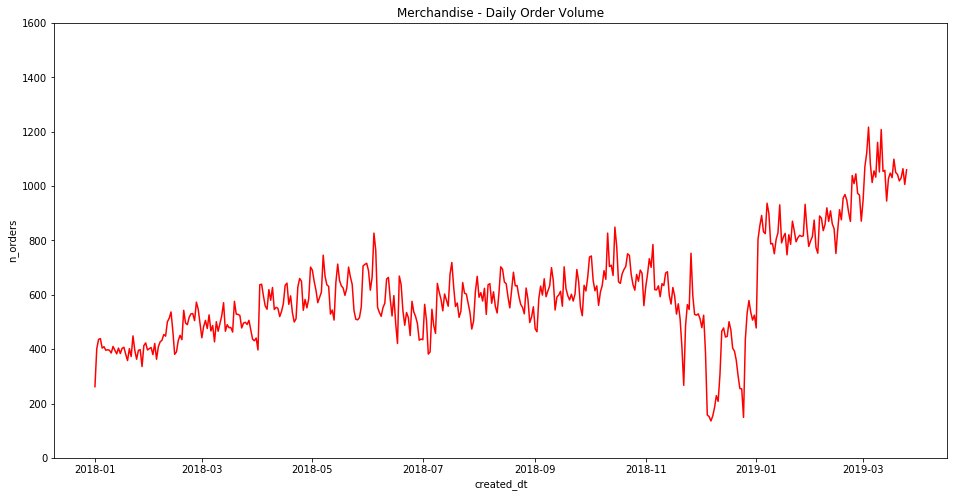

In [80]:
order_volume = order_facts[order_facts.n_merchandise > 0][['created_mt', 'created_dt', 'order_id']]\
            .groupby(['created_mt', 'created_dt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 8))
plt.ylim([0, 1600])
sns.lineplot(x = 'created_dt', y = 'n_orders', color = "red", data=order_volume)
plt.title('Merchandise - Daily Order Volume')
plt.show()

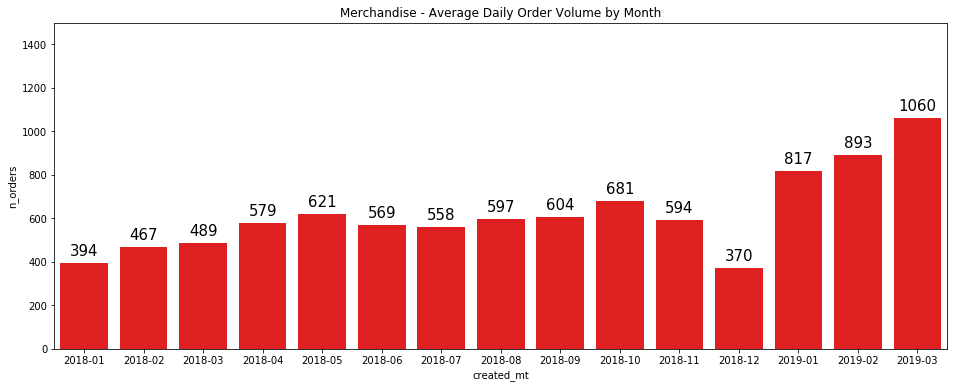

In [81]:
avg_daily_order_volume = order_volume[['created_mt', 'n_orders']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 1500])
g = sns.barplot(x = 'created_mt', y = 'n_orders', color = 'red', data=avg_daily_order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Merchandise - Average Daily Order Volume by Month')
plt.show()

In [82]:
avg_daily_order_volume['lag'] = avg_daily_order_volume.n_orders.shift()
avg_daily_order_volume['change'] = (avg_daily_order_volume.n_orders - avg_daily_order_volume.lag)/avg_daily_order_volume.lag
avg_daily_order_volume

,created_mt,n_orders,lag,change
0,2018-01,393.580645,NaN,NaN
1,2018-02,466.964286,393.580645,0.186451
2,2018-03,488.870968,466.964286,0.046913
3,2018-04,578.900000,488.870968,0.184157
4,2018-05,621.161290,578.900000,0.073003
5,2018-06,568.966667,621.161290,-0.084027
6,2018-07,558.451613,568.966667,-0.018481
7,2018-08,596.870968,558.451613,0.068796
8,2018-09,604.433333,596.870968,0.012670
9,2018-10,681.161290,604.433333,0.126942


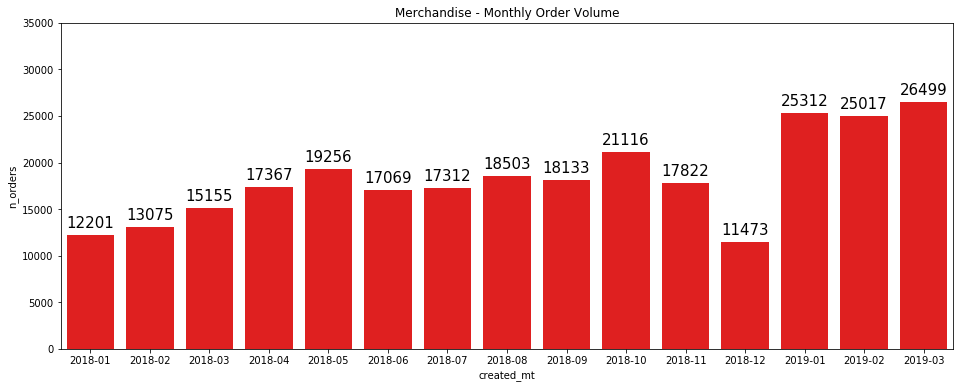

In [83]:
monthly_order_volume = order_volume[['created_mt', 'n_orders']].groupby('created_mt').sum().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 35000])
g = sns.barplot(x = 'created_mt', y = 'n_orders', color = 'red', data=monthly_order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Merchandise - Monthly Order Volume')
plt.show()

In [84]:
monthly_order_volume['lag_n_orders'] = monthly_order_volume.n_orders.shift()
monthly_order_volume['change'] = (monthly_order_volume.n_orders - monthly_order_volume.lag_n_orders)/monthly_order_volume.lag_n_orders
monthly_order_volume

,created_mt,n_orders,lag_n_orders,change
0,2018-01,12201,NaN,NaN
1,2018-02,13075,12201.0,0.071633
2,2018-03,15155,13075.0,0.159082
3,2018-04,17367,15155.0,0.145958
4,2018-05,19256,17367.0,0.108770
5,2018-06,17069,19256.0,-0.113575
6,2018-07,17312,17069.0,0.014236
7,2018-08,18503,17312.0,0.068796
8,2018-09,18133,18503.0,-0.019997
9,2018-10,21116,18133.0,0.164507


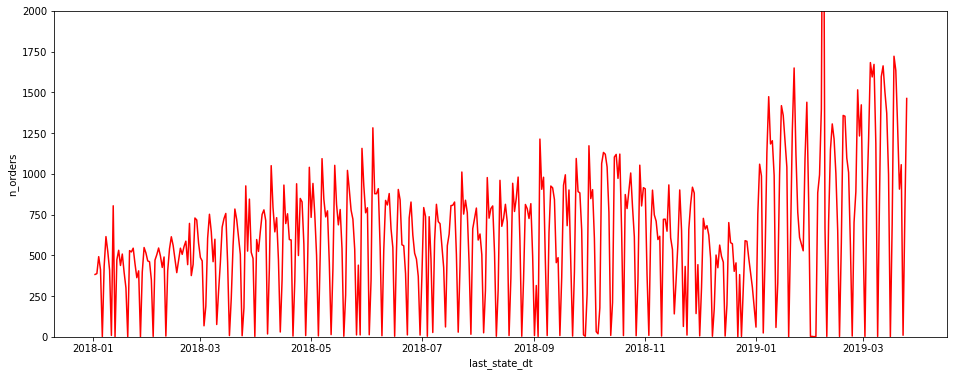

In [85]:
# Check volumes by ship date
order_volume = order_facts[order_facts.n_merchandise > 0][['last_state_dt', 'order_id']]\
            .groupby(['last_state_dt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 2000])
sns.lineplot(x = 'last_state_dt', y = 'n_orders', color = "red", data=order_volume)
plt.show()

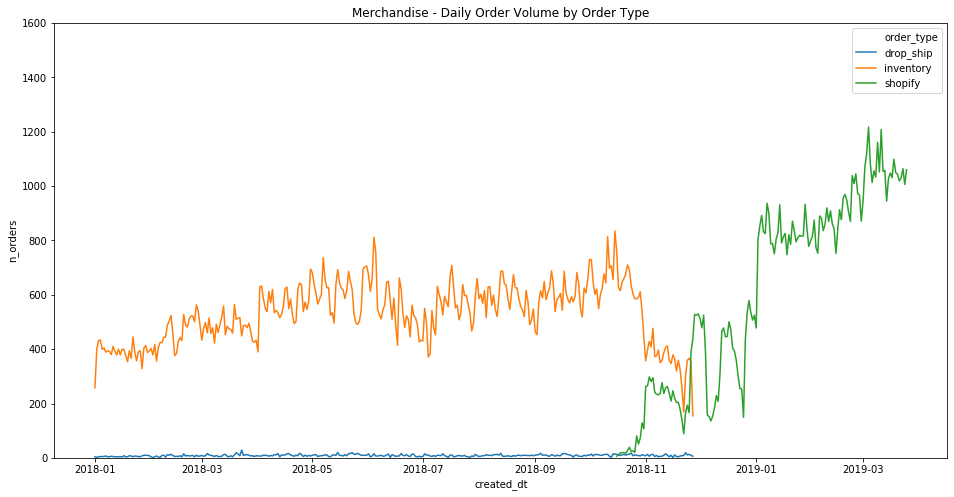

In [86]:
# I was also interested in looking at drop-ship vs inventory, but the drop ship flag stops
# appearing after the transition to shopify

order_volume = order_facts[order_facts.n_merchandise > 0][['created_mt', 'created_dt', 'order_type', 'order_id']]\
            .groupby(['created_mt', 'created_dt', 'order_type'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})
# Order Type Merchandise Volumes
plt.figure(figsize=(16, 8))
plt.ylim([0, 1600])
sns.lineplot(x = 'created_dt', y = 'n_orders', hue = 'order_type', data=order_volume)
plt.title('Merchandise - Daily Order Volume by Order Type')
plt.show()

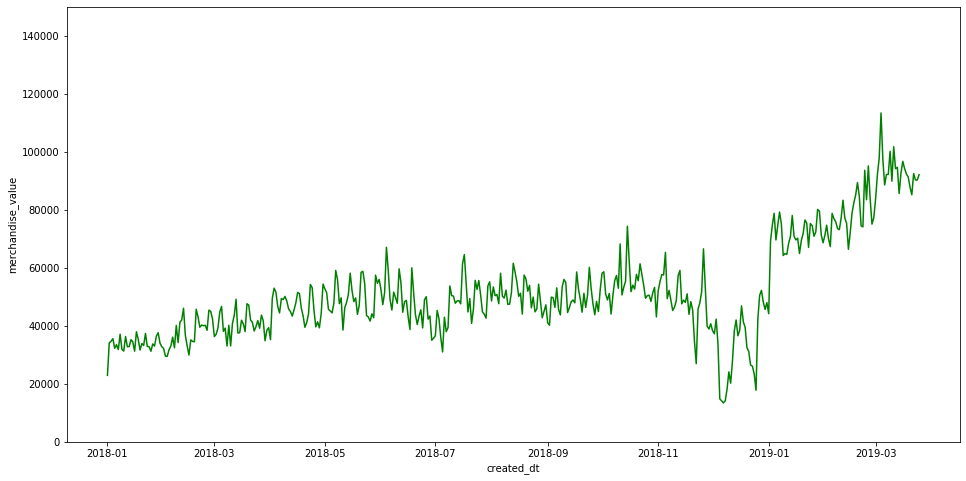

In [87]:
tmp = order_facts[order_facts.n_merchandise > 0][['created_mt', 'created_dt', 'subtotal', 'gift_card_value']]
tmp['merchandise_value'] = tmp.subtotal - tmp.gift_card_value

order_value = tmp[['created_mt', 'created_dt', 'merchandise_value']]\
            .groupby(['created_mt', 'created_dt'])\
            .sum()\
            .reset_index()

order_value.head()

# Order Type Merchandise Value
plt.figure(figsize=(16, 8))
plt.ylim([0, 150000])
sns.lineplot(x = 'created_dt', y = 'merchandise_value', color = 'green', data=order_value)
plt.show()

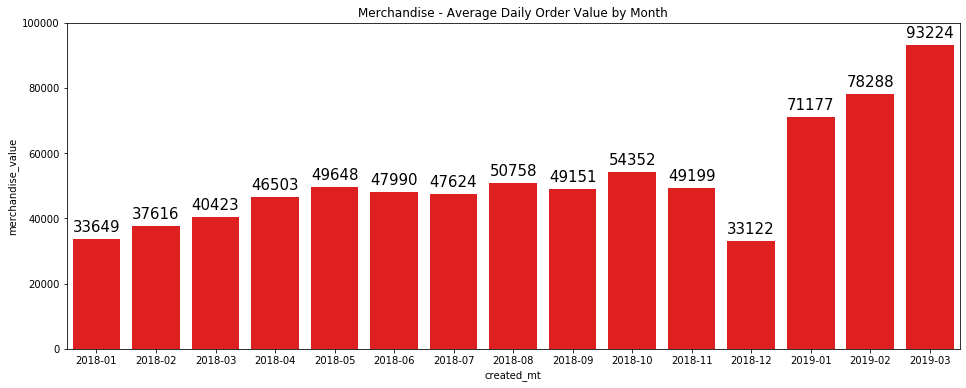

In [88]:
avg_daily_order_value = order_value[['created_mt', 'merchandise_value']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 100000])
g = sns.barplot(x = 'created_mt', y = 'merchandise_value', color = 'red', data=avg_daily_order_value)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Merchandise - Average Daily Order Value by Month')
plt.show()

In [89]:
avg_daily_order_value['lag'] = avg_daily_order_value.merchandise_value.shift()
avg_daily_order_value['change'] = (avg_daily_order_value.merchandise_value - avg_daily_order_value.lag)/avg_daily_order_value.lag
avg_daily_order_value

,created_mt,merchandise_value,lag,change
0,2018-01,33649.224839,NaN,NaN
1,2018-02,37615.835714,33649.224839,0.117881
2,2018-03,40423.360968,37615.835714,0.074637
3,2018-04,46502.573333,40423.360968,0.150389
4,2018-05,49647.966452,46502.573333,0.067639
5,2018-06,47989.745000,49647.966452,-0.033400
6,2018-07,47623.682581,47989.745000,-0.007628
7,2018-08,50757.730000,47623.682581,0.065809
8,2018-09,49151.470000,50757.730000,-0.031646
9,2018-10,54352.235161,49151.470000,0.105811


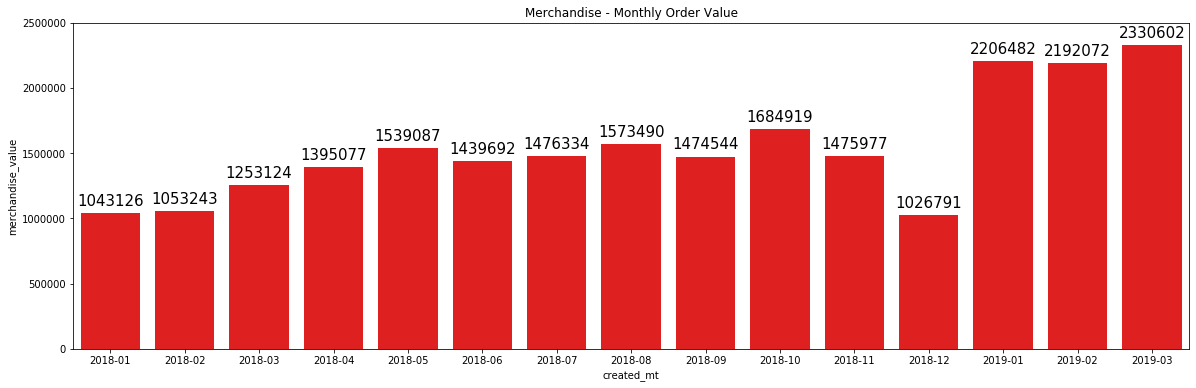

In [90]:
monthly_order_value = order_value[['created_mt', 'merchandise_value']].groupby('created_mt').sum().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(20, 6))
plt.ylim([0, 2500000])
g = sns.barplot(x = 'created_mt', y = 'merchandise_value', color = 'red', data=monthly_order_value)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Merchandise - Monthly Order Value')
plt.show()

In [91]:
monthly_order_value['lag'] = monthly_order_value.merchandise_value.shift()
monthly_order_value['change'] = (monthly_order_value.merchandise_value - monthly_order_value.lag)/monthly_order_value.lag
monthly_order_value

,created_mt,merchandise_value,lag,change
0,2018-01,1043125.97,NaN,NaN
1,2018-02,1053243.40,1043125.97,0.009699
2,2018-03,1253124.19,1053243.40,0.189776
3,2018-04,1395077.20,1253124.19,0.113279
4,2018-05,1539086.96,1395077.20,0.103227
5,2018-06,1439692.35,1539086.96,-0.064580
6,2018-07,1476334.16,1439692.35,0.025451
7,2018-08,1573489.63,1476334.16,0.065809
8,2018-09,1474544.10,1573489.63,-0.062883
9,2018-10,1684919.29,1474544.10,0.142671


## Baby Boxes Order Volumes

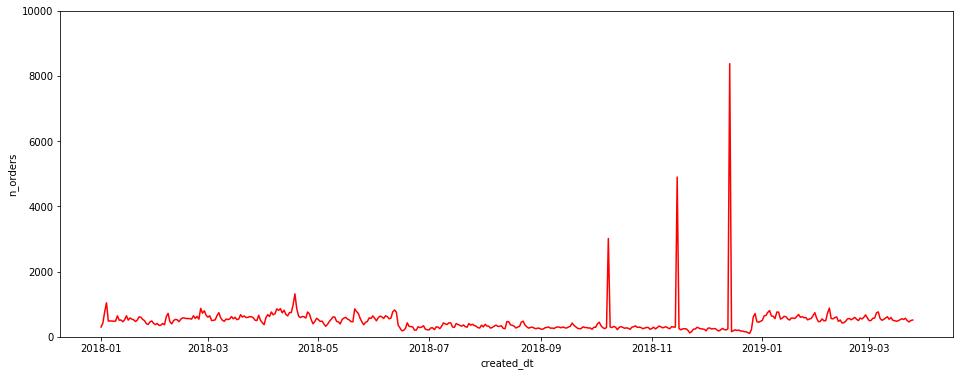

In [92]:
# Looks like baby boxes were batch added on a single day in Oct, Nov, Dec 2018
# this might be easier to look at monthly
order_volume = order_facts[order_facts.baby_box > 0][['created_mt', 'created_dt', 'order_id']]\
            .groupby(['created_mt', 'created_dt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 10000])
sns.lineplot(x = 'created_dt', y = 'n_orders', color = "red", data=order_volume)
plt.show()

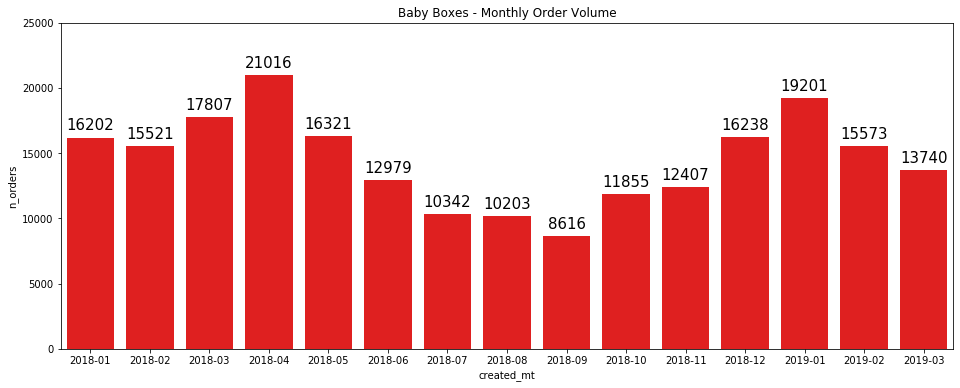

In [93]:
order_volume = order_facts[order_facts.baby_box > 0][['created_mt', 'order_id']]\
            .groupby(['created_mt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 25000])
g=sns.barplot(x = 'created_mt', y = 'n_orders', color = "red", data=order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Baby Boxes - Monthly Order Volume')
plt.show()

In [94]:
order_volume['days'] = order_facts[['created_mt', 'created_dt']].groupby('created_mt').nunique().reset_index()['created_dt']
order_volume['daily_orders'] = order_volume['n_orders']/order_volume['days']
order_volume['lag'] = order_volume['daily_orders'].shift()
order_volume['change'] = (order_volume.daily_orders-order_volume.lag)/order_volume.lag
order_volume.tail(6)

,created_mt,n_orders,days,daily_orders,lag,change
9,2018-10,11855,31,382.419355,287.200000,0.331544
10,2018-11,12407,30,413.566667,382.419355,0.081448
11,2018-12,16238,31,523.806452,413.566667,0.266559
12,2019-01,19201,31,619.387097,523.806452,0.182473
13,2019-02,15573,28,556.178571,619.387097,-0.102050
14,2019-03,13740,25,549.600000,556.178571,-0.011828


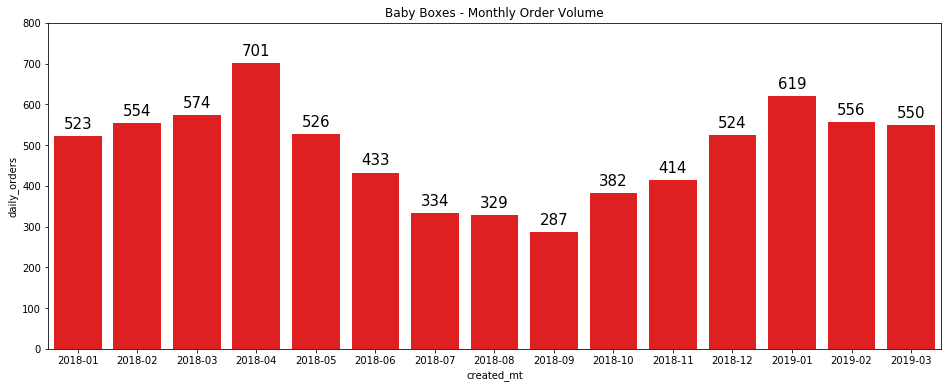

In [95]:
# Baby Box Avg Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 800])
g=sns.barplot(x = 'created_mt', y = 'daily_orders', color = "red", data=order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Baby Boxes - Monthly Order Volume')
plt.show()

## Cash Funds

In [96]:
order_facts.columns

Index(['order_id', 'purchaser_id', 'recipient_registry_id', 'user_id', 'state',
       'total', 'subtotal', 'tax', 'shipping', 'created_at', 'order_type',
       'created_dt', 'created_mt', 'anon_user', 'baby_box', 'fund',
       'gift_card', 'bottle', 'gift_card_value', 'n_line_items',
       'n_merchandise', 'merchandise_value', 'n_states', 'last_state',
       'last_state_at', 'last_state_dt', 'payment_hold', 'fraud_hold',
       'operator_hold', 'fulfillment_hours'],
      dtype='object')

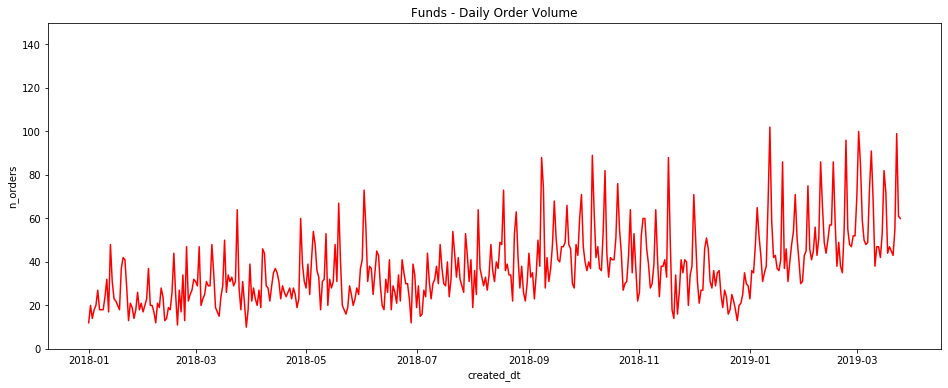

In [97]:
order_volume = order_facts[order_facts.fund > 0][['created_mt', 'created_dt', 'order_id']]\
            .groupby(['created_mt', 'created_dt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 150])
sns.lineplot(x = 'created_dt', y = 'n_orders', color = "red", data=order_volume)
plt.title('Funds - Daily Order Volume')
plt.show()

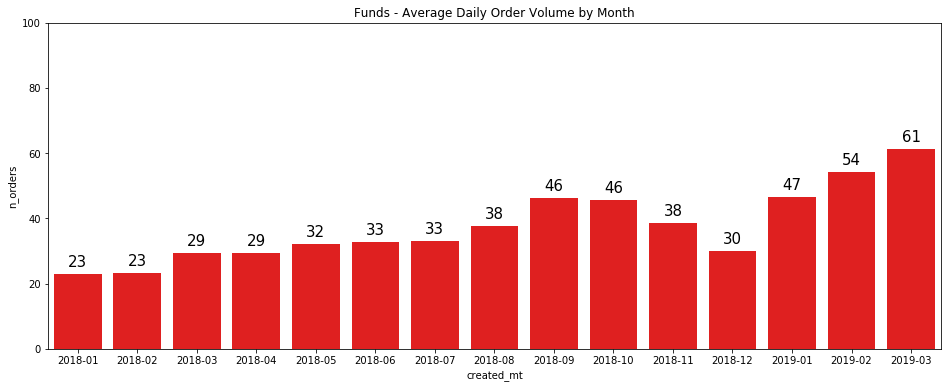

In [98]:
avg_daily_order_volume = order_volume[['created_mt', 'n_orders']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 100])
g = sns.barplot(x = 'created_mt', y = 'n_orders', color = 'red', data=avg_daily_order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Funds - Average Daily Order Volume by Month')
plt.show()

In [99]:
avg_daily_order_volume['lag'] = avg_daily_order_volume.n_orders.shift()
avg_daily_order_volume['change'] = (avg_daily_order_volume.n_orders-avg_daily_order_volume.lag)/avg_daily_order_volume.lag
avg_daily_order_volume

,created_mt,n_orders,lag,change
0,2018-01,23.064516,NaN,NaN
1,2018-02,23.392857,23.064516,0.014236
2,2018-03,29.483871,23.392857,0.260379
3,2018-04,29.300000,29.483871,-0.006236
4,2018-05,32.096774,29.300000,0.095453
5,2018-06,32.800000,32.096774,0.021910
6,2018-07,33.096774,32.800000,0.009048
7,2018-08,37.612903,33.096774,0.136452
8,2018-09,46.266667,37.612903,0.230074
9,2018-10,45.774194,46.266667,-0.010644


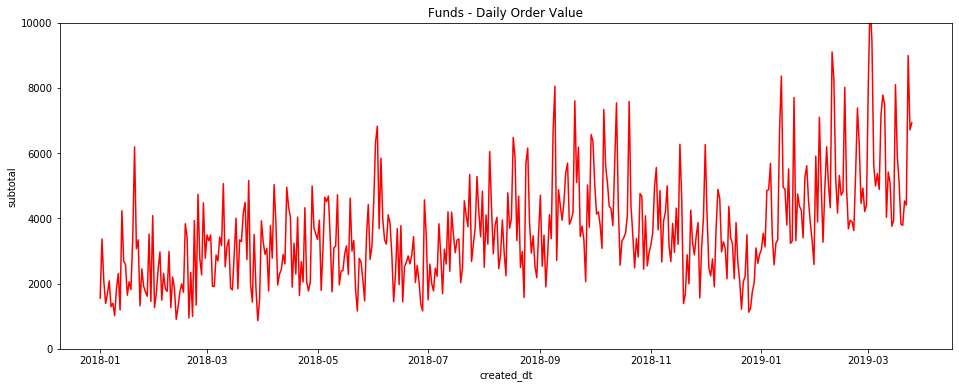

In [100]:
order_value = order_facts[order_facts.fund > 0][['created_mt', 'created_dt', 'subtotal']]\
            .groupby(['created_mt', 'created_dt'])\
            .sum()\
            .reset_index()

plt.figure(figsize=(16, 6))
plt.ylim([0, 10000])
sns.lineplot(x = 'created_dt', y = 'subtotal', color = "red", data=order_value)
plt.title('Funds - Daily Order Value')
plt.show()

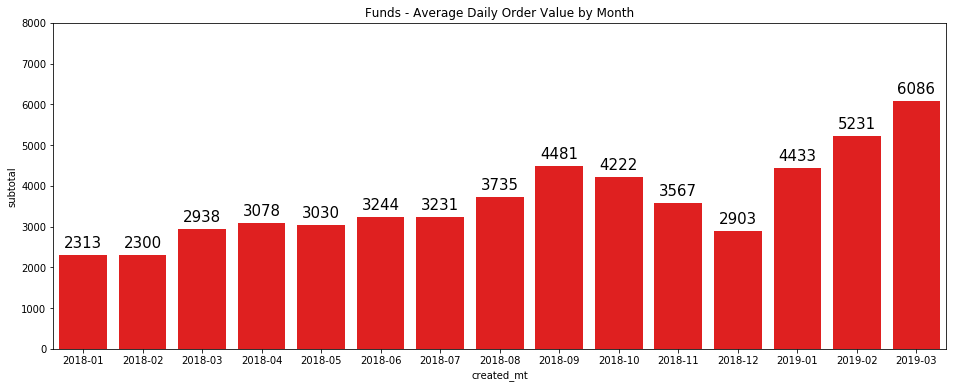

In [101]:
avg_daily_order_value = order_value[['created_mt', 'subtotal']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 8000])
g = sns.barplot(x = 'created_mt', y = 'subtotal', color = 'red', data=avg_daily_order_value)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Funds - Average Daily Order Value by Month')
plt.show()

## Gift Cards

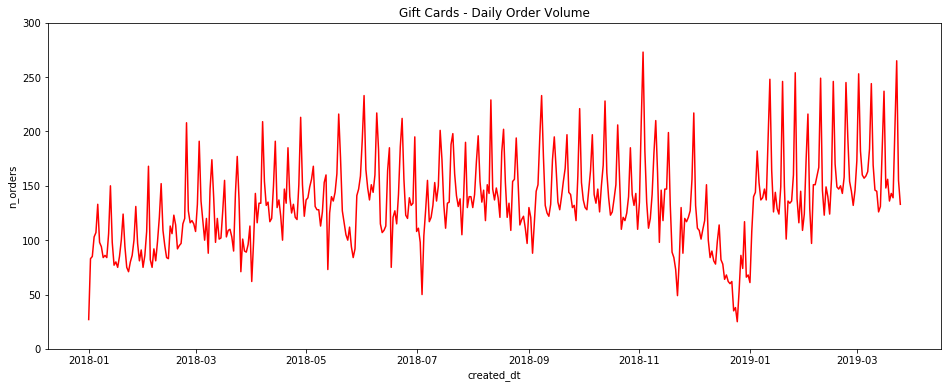

In [102]:
order_volume = order_facts[order_facts.gift_card > 0][['created_mt', 'created_dt', 'order_id']]\
            .groupby(['created_mt', 'created_dt'])\
            .count()\
            .reset_index()\
            .rename(columns={'order_id': 'n_orders'})

# Merchandise Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 300])
sns.lineplot(x = 'created_dt', y = 'n_orders', color = "red", data=order_volume)
plt.title('Gift Cards - Daily Order Volume')
plt.show()

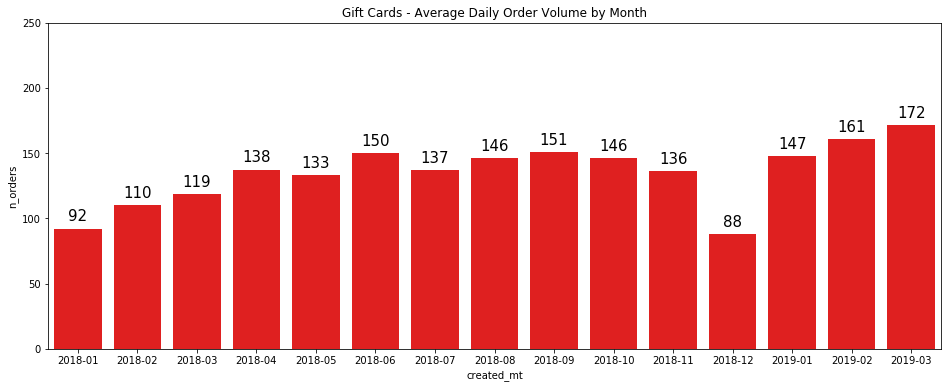

In [103]:
avg_daily_order_volume = order_volume[['created_mt', 'n_orders']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 250])
g = sns.barplot(x = 'created_mt', y = 'n_orders', color = 'red', data=avg_daily_order_volume)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Gift Cards - Average Daily Order Volume by Month')
plt.show()

In [104]:
avg_daily_order_volume['lag'] = avg_daily_order_volume.n_orders.shift()
avg_daily_order_volume['change'] = (avg_daily_order_volume.n_orders - avg_daily_order_volume.lag)/avg_daily_order_volume.lag
avg_daily_order_volume

,created_mt,n_orders,lag,change
0,2018-01,92.258065,NaN,NaN
1,2018-02,110.500000,92.258065,0.197727
2,2018-03,119.000000,110.500000,0.076923
3,2018-04,137.500000,119.000000,0.155462
4,2018-05,133.419355,137.500000,-0.029677
5,2018-06,150.000000,133.419355,0.124275
6,2018-07,137.258065,150.000000,-0.084946
7,2018-08,146.096774,137.258065,0.064395
8,2018-09,150.733333,146.096774,0.031736
9,2018-10,146.032258,150.733333,-0.031188


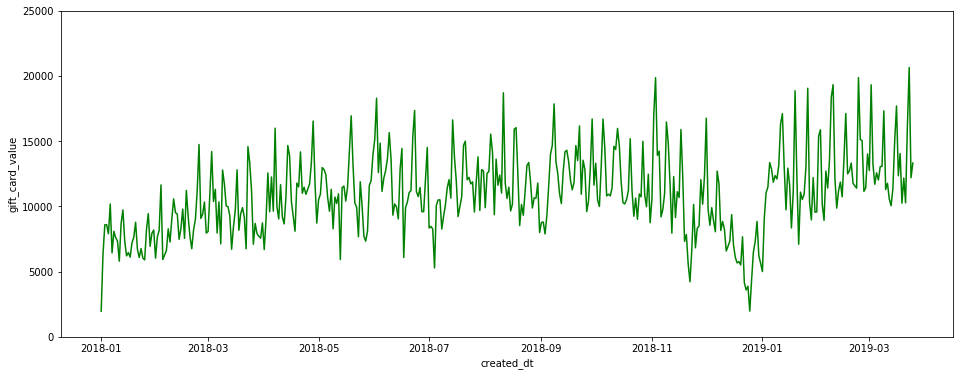

In [105]:
order_value = order_facts[['created_mt', 'created_dt', 'gift_card_value']]\
            .groupby(['created_mt', 'created_dt'])\
            .sum()\
            .reset_index()

order_value.head()

# Order Type Merchandise Value
plt.figure(figsize=(16, 6))
plt.ylim([0, 25000])
sns.lineplot(x = 'created_dt', y = 'gift_card_value', color = 'green', data=order_value)
plt.show()

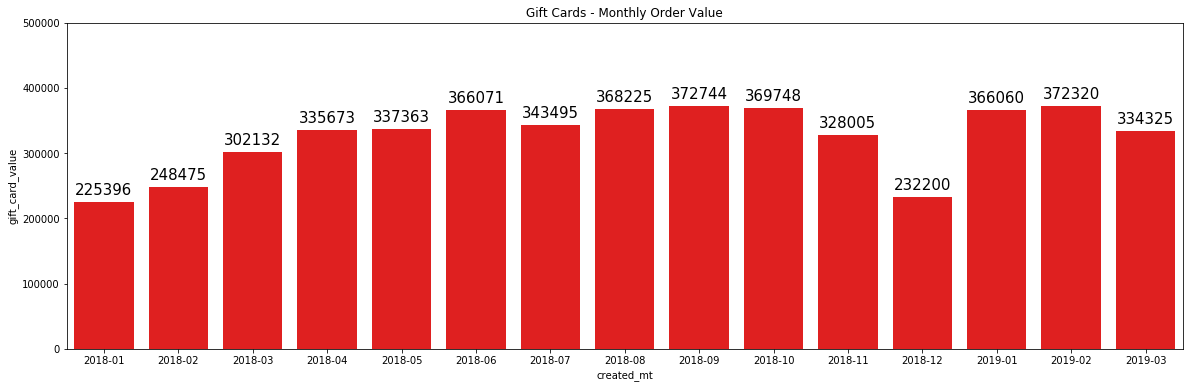

In [106]:
monthly_order_value = order_value[['created_mt', 'gift_card_value']].groupby('created_mt').sum().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(20, 6))
plt.ylim([0, 500000])
g = sns.barplot(x = 'created_mt', y = 'gift_card_value', color = 'red', data=monthly_order_value)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Gift Cards - Monthly Order Value')
plt.show()

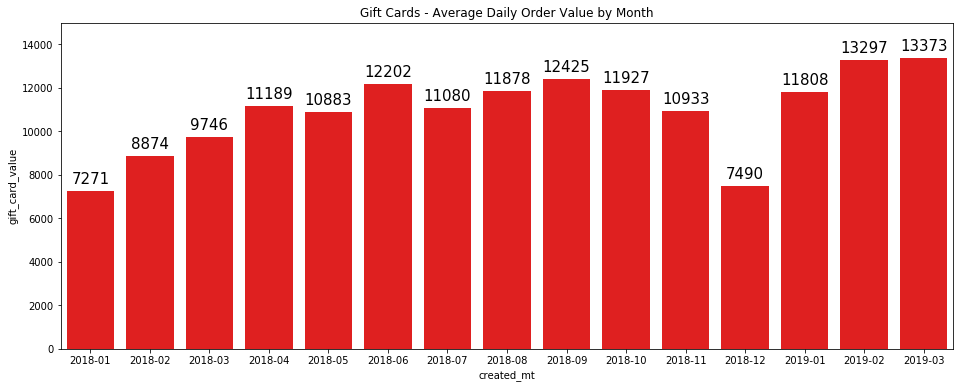

In [107]:
avg_daily_order_value = order_value[['created_mt', 'gift_card_value']].groupby('created_mt').mean().reset_index()

# Average Daily Order Volume
plt.figure(figsize=(16, 6))
plt.ylim([0, 15000])
g = sns.barplot(x = 'created_mt', y = 'gift_card_value', color = 'red', data=avg_daily_order_value)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
    
plt.title('Gift Cards - Average Daily Order Value by Month')
plt.show()

## Monthly Volume/Value Breakdown

In [108]:
# Volume
merch = order_facts[order_facts.n_merchandise > 0][['created_dt', 'order_id']].groupby('created_dt').count().rename(columns={'order_id': 'merchandise'})
gift_card = order_facts[order_facts.gift_card > 0][['created_dt', 'order_id']].groupby('created_dt').count().rename(columns={'order_id': 'gift_card'})
fund = order_facts[order_facts.fund > 0][['created_dt', 'order_id']].groupby('created_dt').count().rename(columns={'order_id': 'fund'})
baby_box = order_facts[order_facts.baby_box > 0][['created_dt', 'order_id']].groupby('created_dt').count().rename(columns={'order_id': 'baby_box'})

merch.join(gift_card).join(fund).join(baby_box).to_csv('data/order_volumes.csv')

In [109]:
# Value
merch = order_facts[order_facts.n_merchandise > 0][['created_dt', 'merchandise_value']].groupby('created_dt').sum().rename(columns={'order_id': 'merchandise'})
gift_card = order_facts[order_facts.gift_card > 0][['created_dt', 'gift_card_value']].groupby('created_dt').sum().rename(columns={'order_id': 'gift_card'})
fund = order_facts[order_facts.fund > 0][['created_dt', 'subtotal']].groupby('created_dt').sum().rename(columns={'order_id': 'fund'})

merch.join(gift_card).join(fund).to_csv('data/order_values.csv')

In [110]:
merch.join(gift_card).join(fund)

,merchandise_value,gift_card_value,subtotal
created_dt,,,
2018-01-01,22952.33,1970.0,1555.0
2018-01-02,34148.36,6350.0,3370.0
2018-01-03,34688.73,8591.0,2095.0
2018-01-04,35600.19,8600.0,1395.0
2018-01-05,32287.48,7905.0,1681.0
...,...,...,...
2019-03-21,85227.73,10275.0,4535.0
2019-03-22,92547.35,16150.0,4410.0
2019-03-23,90362.17,20650.0,8995.0


## Bottle Trends

In [111]:
items['bottle_price'] = items.bottle * items.price

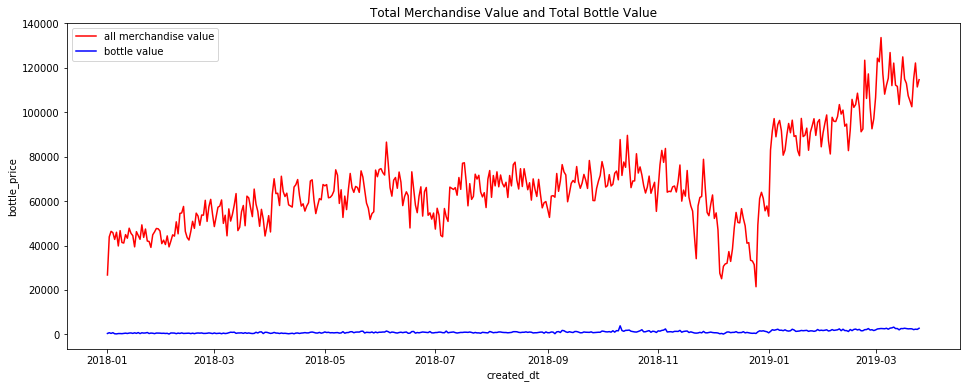

In [112]:
# What % of sales are bottles contributing over time

order_value = items[['created_mt', 'created_dt', 'price', 'bottle_price']].\
    groupby(['created_mt', 'created_dt']).\
    sum().\
    reset_index()
order_value['pr_bottle'] = order_value.bottle_price.div(order_value.price)
order_value.to_csv('data/bottle_value.csv')

plt.figure(figsize=(16, 6))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_dt', y = 'price', color = 'red', data=order_value, label='all merchandise value')
g = sns.lineplot(x = 'created_dt', y = 'bottle_price', color = 'blue', data=order_value, label='bottle value')
g.legend()
    
plt.title('Total Merchandise Value and Total Bottle Value')
plt.show()

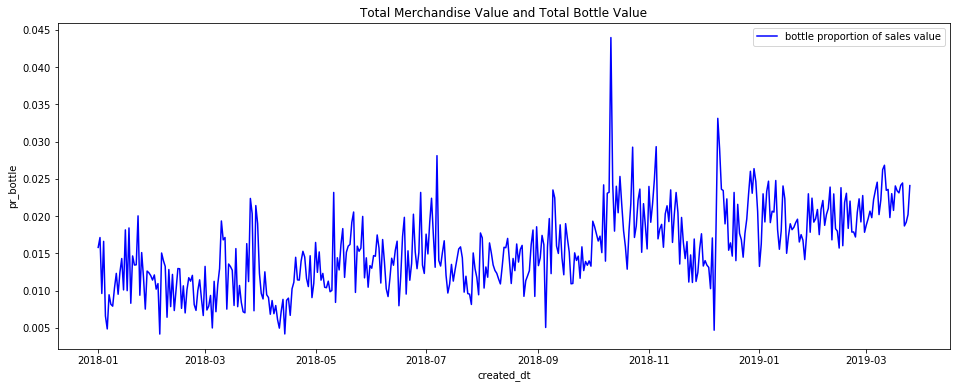

In [113]:
plt.figure(figsize=(16, 6))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_dt', y = 'pr_bottle', color = 'blue', data=order_value, label='bottle proportion of sales value')
g.legend()
    
plt.title('Total Merchandise Value and Total Bottle Value')
plt.show()

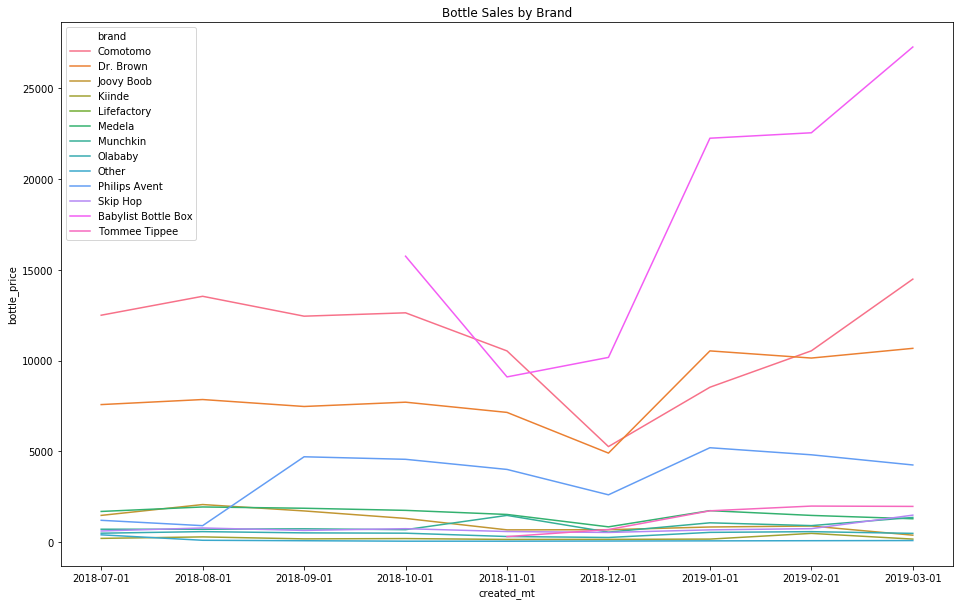

In [114]:
# What is the breakdown of bottle by brand?
# Again, brands/product types would be coded more formally in db rather than relying on string-matching
def code_bottles(name):
    if 'Babylist Bottle Box' in name:
        return 'Babylist Bottle Box'
    elif 'Comotomo' in name:
        return 'Comotomo'
    elif 'Dr. Brown' in name:
        return 'Dr. Brown'
    elif 'Tommee Tippee' in name:
        return 'Tommee Tippee'
    elif 'Philips' in name or 'Avent' in name:
        return 'Philips Avent'
    elif 'OXO' in name:
        return 'OXO'
    elif 'Medela' in name:
        return 'Medela'
    elif 'Joovy Boob' in name:
        return 'Joovy Boob'
    elif 'Kiinde' in name:
        return 'Kiinde'
    elif 'Munchkin' in name:
        return 'Munchkin'
    elif 'Skip Hop' in name:
        return 'Skip Hop'
    elif 'Olababy' in name:
        return 'Olababy'
    elif 'Lifefactory' in name:
        return 'Lifefactory'
    else:
        return 'Other'
    
bottles = items[items.bottle].copy()
bottles['brand'] = bottles.name.apply(lambda x: code_bottles(x))

bottle_value = bottles[['created_mt', 'brand', 'bottle_price']].groupby(['created_mt', 'brand']).sum('bottle_price').reset_index()
bottle_value['created_mt'] = pd.to_datetime(bottle_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'bottle_price', hue = 'brand', data=bottle_value[bottle_value.created_mt >= '2018-07-01'])
g.legend()
    
plt.title('Bottle Sales by Brand')
plt.show()

bottle_value\
    .pivot_table(index='created_mt', columns='brand', values='bottle_price')\
    .to_csv('data/bottle_value_brand.csv')

## Movement in some popular "classic" baby items

In [115]:
items[np.logical_not(items.baby_box)&np.logical_not(items.fund)&np.logical_not(items.gift_card)][['name', 'price']]\
    .groupby('name')\
    .agg(['count', 'mean'])\
    .sort_values(('price','count'), ascending=False)\
    .head(10)

price            
                                                   count        mean
name                                                                
Hatch Baby Rest Night Light and Sound Machine       8897   59.608207
Vulli Sophie the Giraffe Teether                    4300   23.753040
Ubbi Steel Diaper Pail - White                      4151   69.207401
Babylist Bottle Box                                 4000   25.489800
FridaBaby NoseFrida The Snotsucker Nasal Aspirator  3904   15.587779
Britax Back Seat Mirror - Silver                    3560   16.310138
Summer Infant 2-Sided Changing Pad                  3484   24.579966
Philips Avent Soothie Pacifier (2 Pack) - Green     3420    4.162208
Boppy Newborn Lounger - Elephant Love               3362   30.404465
Lovevery The Play Gym                               2946  138.641460

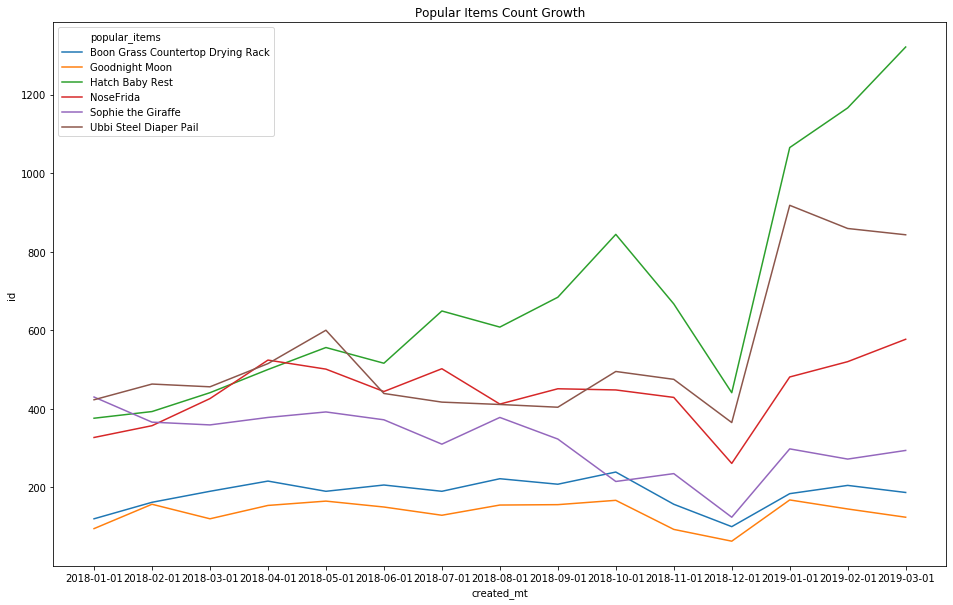

In [116]:
# What is the breakdown of bottle by brand?
# Again, brands/product types would be coded more formally in db rather than relying on string-matching
def popular_items(name):
    if 'Hatch Baby Rest' in name:
        return 'Hatch Baby Rest'
    elif 'Sophie the Giraffe' in name:
        return 'Sophie the Giraffe'
    elif 'NoseFrida' in name:
        return 'NoseFrida'
    elif 'Ubbi Steel Diaper Pail' in name:
        return 'Ubbi Steel Diaper Pail'
    elif 'Goodnight Moon' in name:
        return 'Goodnight Moon'
    elif 'Boon Grass Countertop Drying Rack' in name:
        return 'Boon Grass Countertop Drying Rack'
    else:
        return 'Other'

items['popular_items'] = items.name.apply(lambda x: popular_items(x))
popular_items = items[items.popular_items != 'Other'][['created_mt', 'popular_items', 'id']]\
                                .groupby(['created_mt', 'popular_items'])\
                                .count()\
                                .reset_index()
popular_items['created_mt'] = pd.to_datetime(popular_items['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'id', hue = 'popular_items', data=popular_items)
g.legend()
    
plt.title('Popular Items Count Growth')
plt.show()

popular_items\
    .pivot_table(index='created_mt', columns='popular_items', values='id')\
    .to_csv('data/popular_items.csv')

total_items = items[['created_mt','id']]\
                                .groupby(['created_mt'])\
                                .count()\
                                .reset_index()
total_items.to_csv('data/total_items.csv')

## Users vs Non-Users

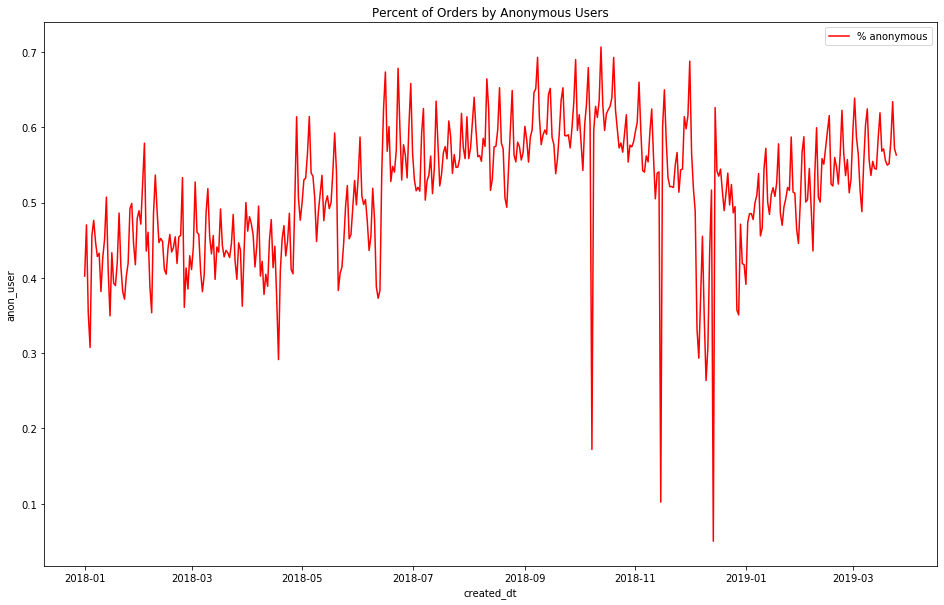

In [117]:
anonymous_users = order_facts[['created_dt', 'anon_user']].groupby('created_dt').mean().reset_index()

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_dt', y = 'anon_user', color = 'red', data=anonymous_users, label = '% anonymous')
g.legend()
    
plt.title('Percent of Orders by Anonymous Users')
plt.show()

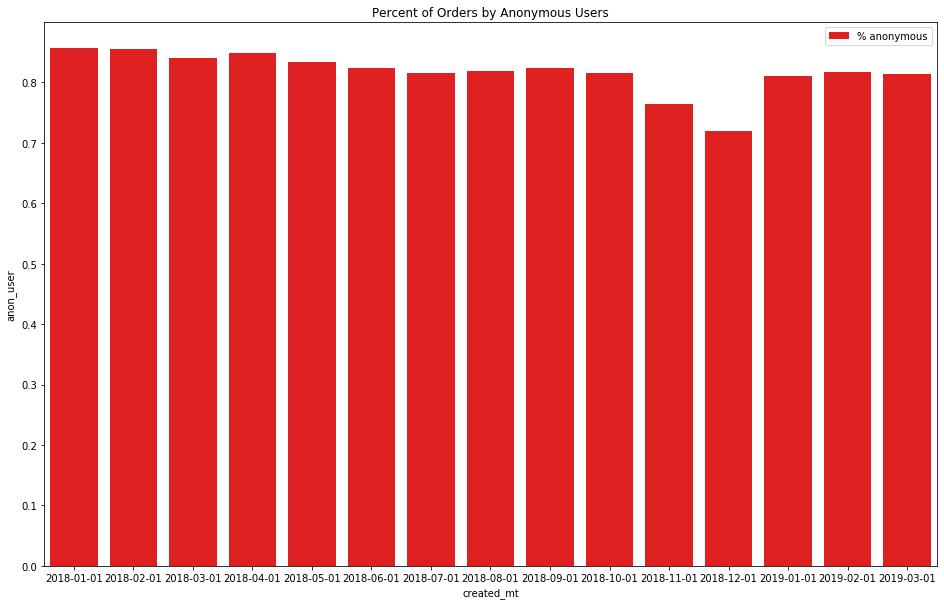

In [118]:
anonymous_users = order_facts[np.logical_not(order_facts.baby_box)][['created_mt', 'anon_user']].groupby('created_mt').mean().reset_index()
anonymous_users['created_mt'] = pd.to_datetime(anonymous_users['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.barplot(x = 'created_mt', y = 'anon_user', color = 'red', data=anonymous_users, label = '% anonymous')
g.legend()
    
plt.title('Percent of Orders by Anonymous Users')
plt.show()

anonymous_users.to_csv('data/anonymous_users.csv')

In [119]:
# Merchandise Orders
order_facts[order_facts.n_merchandise>0][['created_mt', 'anon_user']].groupby('created_mt').mean().reset_index()

,created_mt,anon_user
0,2018-01,0.816327
1,2018-02,0.817055
2,2018-03,0.792544
3,2018-04,0.806587
4,2018-05,0.791130
5,2018-06,0.769114
6,2018-07,0.761495
7,2018-08,0.763606
8,2018-09,0.767606
9,2018-10,0.766291


In [120]:
# Cash fund orders
order_facts[order_facts.fund>0][['created_mt', 'anon_user']].groupby('created_mt').mean().reset_index()

,created_mt,anon_user
0,2018-01,0.991608
1,2018-02,0.987786
2,2018-03,0.992341
3,2018-04,0.990899
4,2018-05,0.992965
5,2018-06,0.993902
6,2018-07,0.986355
7,2018-08,0.989708
8,2018-09,0.987752
9,2018-10,0.981677


In [121]:
# Gift card orders
order_facts[order_facts.gift_card>0][['created_mt', 'anon_user']].groupby('created_mt').mean().reset_index()

,created_mt,anon_user
0,2018-01,0.993706
1,2018-02,0.989657
2,2018-03,0.994850
3,2018-04,0.994182
4,2018-05,0.991779
5,2018-06,0.995778
6,2018-07,0.994360
7,2018-08,0.995584
8,2018-09,0.996904
9,2018-10,0.989618


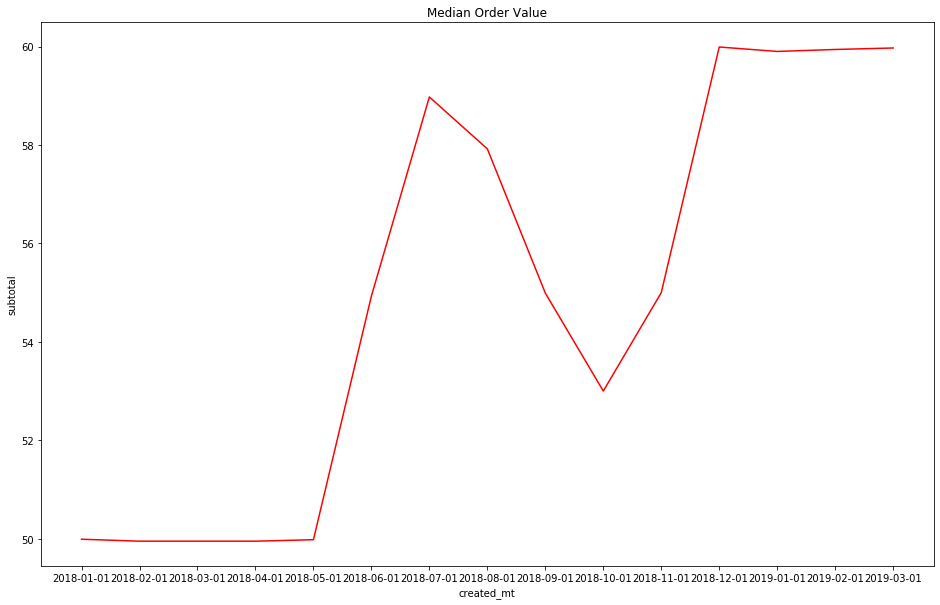

In [122]:
# Median Order Value
average_order_value = order_facts[order_facts.n_merchandise>0][['created_mt', 'subtotal']].groupby(['created_mt']).median().reset_index()
average_order_value['created_mt'] = pd.to_datetime(average_order_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'subtotal', color = 'red', data=average_order_value)
# g.legend()
    
plt.title('Median Order Value')
plt.show()

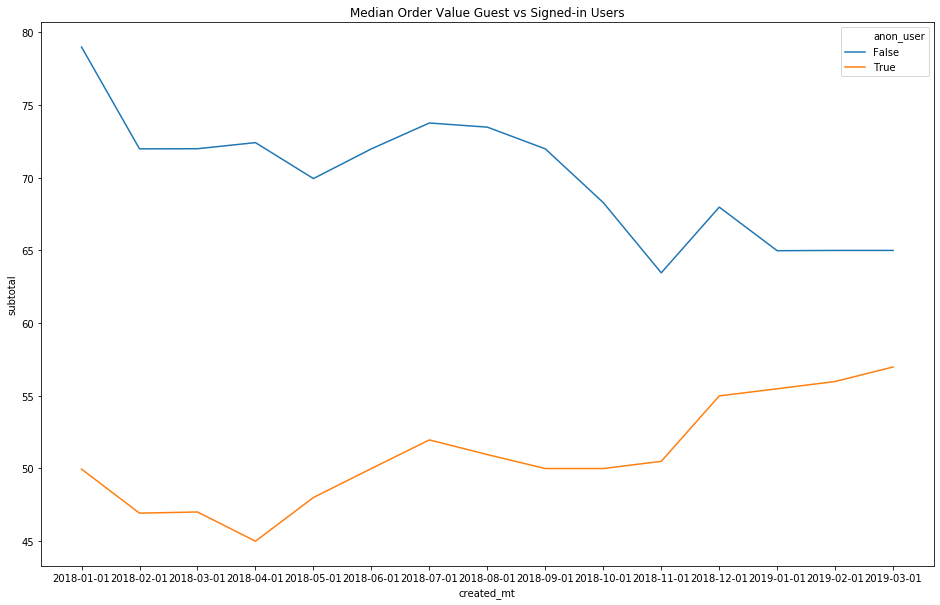

In [123]:
# Median Order Value
average_order_value = order_facts[order_facts.n_merchandise>0][['created_mt', 'anon_user', 'subtotal']].groupby(['created_mt', 'anon_user']).median().reset_index()
average_order_value['created_mt'] = pd.to_datetime(average_order_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'subtotal', hue = 'anon_user', data=average_order_value)
g.legend()
    
plt.title('Median Order Value Guest vs Signed-in Users')
plt.show()

average_order_value.pivot(index='created_mt', columns='anon_user', values='subtotal').to_csv('data/order_value_anon.csv')


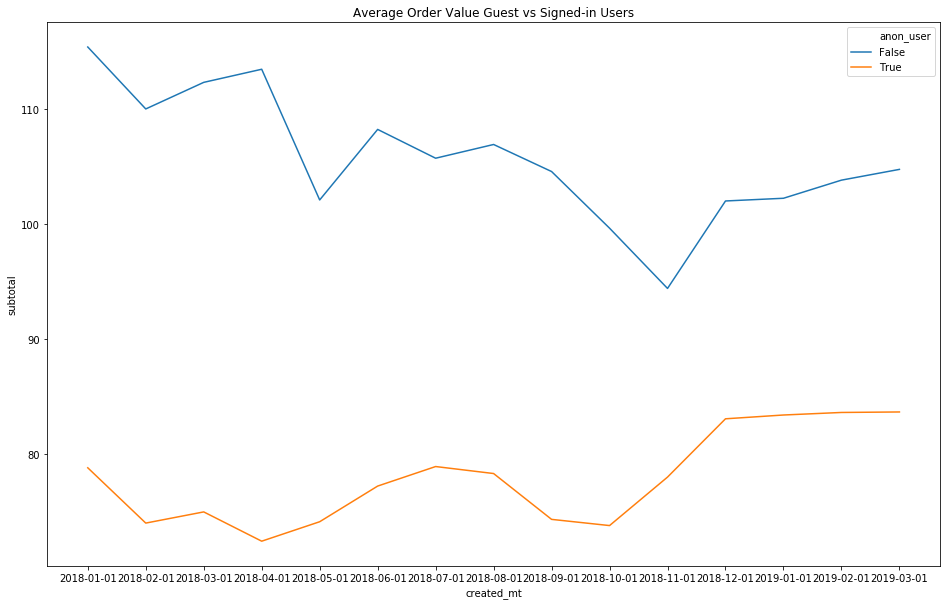

In [124]:
# Median Order Value
average_order_value = order_facts[order_facts.n_merchandise>0][['created_mt', 'anon_user', 'subtotal']].groupby(['created_mt', 'anon_user']).mean().reset_index()
average_order_value['created_mt'] = pd.to_datetime(average_order_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'subtotal', hue = 'anon_user', data=average_order_value)
g.legend()
    
plt.title('Average Order Value Guest vs Signed-in Users')
plt.show()

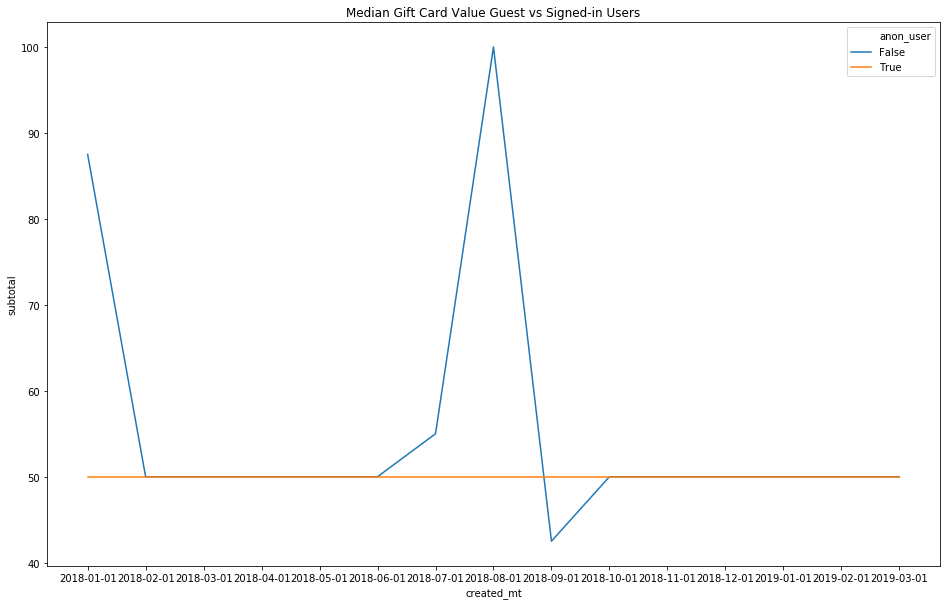

In [125]:
# Median Gift Card Value
average_order_value = order_facts[order_facts.gift_card>0][['created_mt', 'anon_user', 'subtotal']].groupby(['created_mt', 'anon_user']).median().reset_index()
average_order_value['created_mt'] = pd.to_datetime(average_order_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'subtotal', hue = 'anon_user', data=average_order_value)
g.legend()
    
plt.title('Median Gift Card Value Guest vs Signed-in Users')
plt.show()

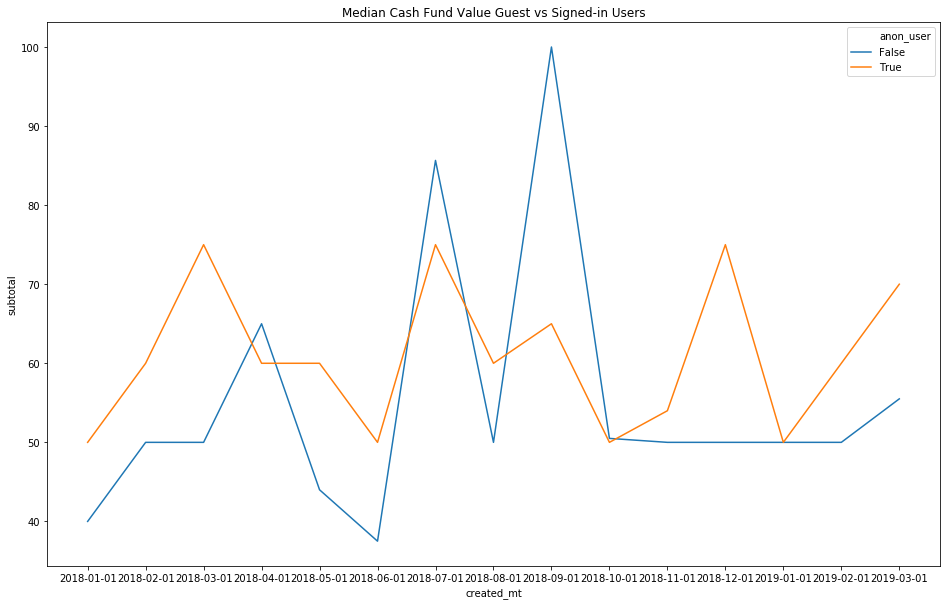

In [126]:
# Median Cash Fund Value
average_order_value = order_facts[order_facts.fund>0][['created_mt', 'anon_user', 'subtotal']].groupby(['created_mt', 'anon_user']).median().reset_index()
average_order_value['created_mt'] = pd.to_datetime(average_order_value['created_mt'].astype(str)).dt.strftime('%Y-%m-%d')

plt.figure(figsize=(16, 10))
# plt.ylim([0, 15000])
g = sns.lineplot(x = 'created_mt', y = 'subtotal', hue = 'anon_user', data=average_order_value)
g.legend()
    
plt.title('Median Cash Fund Value Guest vs Signed-in Users')
plt.show()

## Fulfillment Trends

In [127]:
order_facts.created_mt.sort_values().unique()

<PeriodArray>
['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
 '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
 '2019-03']
Length: 15, dtype: period[M]

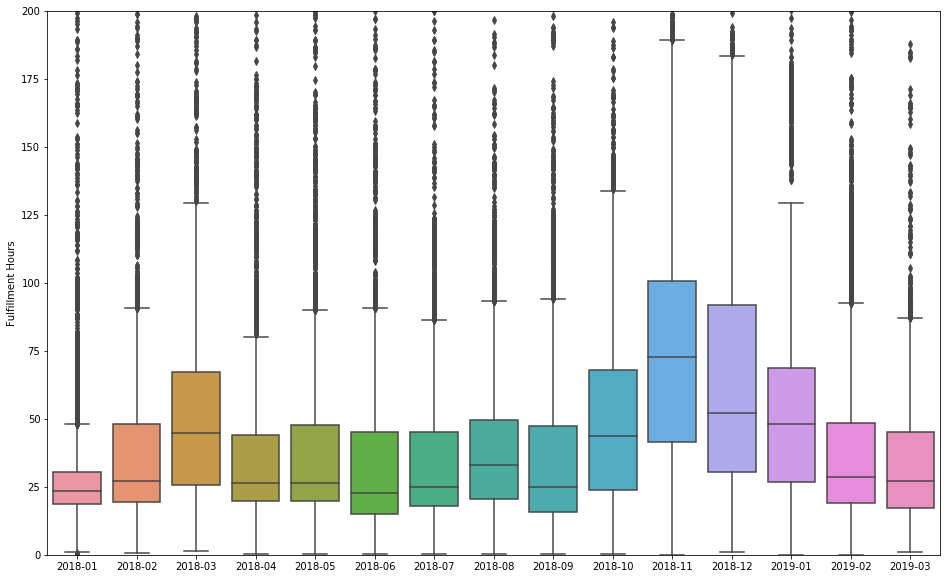

In [128]:
# Really, really long tails fulfillment hours
plt.figure(figsize=(16, 10))
plt.ylim([0, 200])

ax = sns.boxplot(x="created_mt"
                 , y="fulfillment_hours"
                 , order=order_facts.created_mt.sort_values().unique()
                 , data=order_facts[np.logical_and(order_facts.n_merchandise > 0, order_facts.state=='shipped')])
ax.set(xlabel=None)
ax.set(ylabel='Fulfillment Hours')
plt.show()

In [129]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.90)

fulfillment_times = order_facts[np.logical_and(order_facts.n_merchandise > 0, order_facts.state=='shipped')][['created_mt', 'fulfillment_hours']]\
    .groupby('created_mt')\
    .agg(['median', 'std', q25, q75, q90])

fulfillment_times.to_csv('data/fulfillment_times.csv')
fulfillment_times

fulfillment_hours                                              
                      median        std        q25         q75         q90
created_mt                                                                
2018-01            23.418333  47.080742  18.592917   30.429722   51.125444
2018-02            27.023056  52.770779  19.396111   47.956389   73.040833
2018-03            44.721111  47.153455  25.554167   67.338611   87.408833
2018-04            26.451111  30.671998  19.852222   43.981944   54.987556
2018-05            26.534306  30.619147  19.730139   47.863333   68.566028
2018-06            22.761389  34.865586  15.013333   45.284722   65.692500
2018-07            25.042361  33.580618  17.885833   45.264583   56.299194
2018-08            33.097083  68.764337  20.657222   49.719028   70.185139
2018-09            24.897222  53.896822  15.885139   47.213333   72.654222
2018-10            43.703333  38.141324  23.774722   68.009167   94.963500
2018-11            72.852222  50.962196  41.639444  100.782778  135.698778
2018-12            52.278750  41.545721  30.316736   91.734097  112.244639
2019-01            48.121389  41.024365  26.660208   68.796111   93.450194
2019-02            28.628056  36.051285  18.937361   48.379444   69.760833
2019-03            27.197917  21.162670  17.304931   45.232292   59.131500

In [130]:
# Lets call 4 days = 96 hours an extreme long fulfillment time (past 90th percentile most months)
# Focus on recency = 2019
# Are there items that are commonly delayed?

item_fulfillment = pd.merge(items[['order_id', 'name', 'product_id', 'price', 'created_dt']]
                         , order_facts[np.logical_and(order_facts.n_merchandise > 0, order_facts.state=='shipped')][['order_id', 'fulfillment_hours', 'n_merchandise']]
                         , on='order_id' )
item_fulfillment['long_fulfillment_time'] = item_fulfillment.fulfillment_hours > 96

item_fulfillment[item_fulfillment.created_dt >= '2019-01-01'][['name', 'fulfillment_hours']]\
    .groupby('name')\
    .agg(['count', 'median', 'std', q25, q75, q90, 'max'])

fulfillment_hours  \
                                                               count   
name                                                                   
1, 2, 3 to the Zoo: A Counting Book                                9   
10 Little Rubber Ducks                                             7   
100 First Words                                                  176   
3 Sprouts Backseat Organizer - Brown Hedgehog                      1   
3 Sprouts Bath Storage - Penguin                                   3   
...                                                              ...   
i play Snap Reusable Absorbant Swim Diaper - Wh...                16   
i play Snap Reusable Absorbant Swim Diaper - Wh...                 7   
lillebaby Complete All Seasons 6-in-1 Baby Carr...               153   
lillebaby Complete All Seasons 6-in-1 Baby Carr...               107   
lillebaby Complete Original Baby Carrier - Black                  23   

                                                                          \
                                                       median        std   
name                                                                       
1, 2, 3 to the Zoo: A Counting Book                 37.832778  33.102306   
10 Little Rubber Ducks                              48.746389  21.997778   
100 First Words                                     30.583750  30.497015   
3 Sprouts Backseat Organizer - Brown Hedgehog       27.824444        NaN   
3 Sprouts Bath Storage - Penguin                    44.523333  33.903361   
...                                                       ...        ...   
i play Snap Reusable Absorbant Swim Diaper - Wh...  41.842778  27.629107   
i play Snap Reusable Absorbant Swim Diaper - Wh...  42.763333   7.172427   
lillebaby Complete All Seasons 6-in-1 Baby Carr...  38.855556  32.743672   
lillebaby Complete All Seasons 6-in-1 Baby Carr...  27.772778  34.403586   
lillebaby Complete Original Baby Carrier - Black    29.476389  32.819491   

                                                                          \
                                                          q25        q75   
name                                                                       
1, 2, 3 to the Zoo: A Counting Book                 10.014167  43.428056   
10 Little Rubber Ducks                              26.349167  50.632639   
100 First Words                                     20.122778  53.254792   
3 Sprouts Backseat Organizer - Brown Hedgehog       27.824444  27.824444   
3 Sprouts Bath Storage - Penguin                    23.938889  57.561111   
...                                                       ...        ...   
i play Snap Reusable Absorbant Swim Diaper - Wh...  24.493889  49.455069   
i play Snap Reusable Absorbant Swim Diaper - Wh...  39.516667  45.972917   
lillebaby Complete All Seasons 6-in-1 Baby Carr...  18.710556  51.444444   
lillebaby Complete All Seasons 6-in-1 Baby Carr...  19.042222  48.404167   
lillebaby Complete Original Baby Carrier - Black    21.744861  55.297778   

                                                                           
                                                          q90         max  
name                                                                       
1, 2, 3 to the Zoo: A Counting Book                 61.805333  108.936667  
10 Little Rubber Ducks                              58.302722   69.475556  
100 First Words                                     72.558194  167.325000  
3 Sprouts Backseat Organizer - Brown Hedgehog       27.824444   27.824444  
3 Sprouts Bath Storage - Penguin                    65.383778   70.598889  
...                                                       ...         ...  
i play Snap Reusable Absorbant Swim Diaper - Wh...  81.389583  105.898056  
i play Snap Reusable Absorbant Swim Diaper - Wh...  49.160111   52.010278  
lillebaby Complete All Seasons 6-in-1 Baby Carr...  89.179000  168.237222  


In [131]:
long_fulfillment_times = item_fulfillment[item_fulfillment.n_merchandise == 1][['product_id', 'name', 'long_fulfillment_time']]\
    .groupby(['product_id', 'name'])\
    .agg(['count', 'mean', 'sum'])\
    .sort_values(('long_fulfillment_time', 'mean'), ascending=False)

long_fulfillment_times.to_csv('data/long_fulfillment_times.csv')

## Items with more than 10 purchases
## and 4+ day fulfillment times 50%+ of the time heavily represented by furniture
## High chairs / chairs, cribs, rugs and bookcases
## I'd for sure be building a proper item category taxonomy & brand lookup, as I'm sure there are some 
## super interesting patterns to look at there!
select = (long_fulfillment_times.long_fulfillment_time['count']>10) & (long_fulfillment_times.long_fulfillment_time['mean']>.5)
long_fulfillment_times[select].sort_values(('long_fulfillment_time', 'mean'), ascending = False).head(40)

long_fulfillment_time  \
                                                                              count   
product_id name                                                                       
19270.0    OXO Tot Sprout High Chair - Navy/Walnut                               12   
19256.0    OXO Tot Sprout High Chair - Grey/White                                21   
6982.0     OXO Tot Sprout Chair - Taupe/Birch                                    12   
4282.0     OXO Tot Sprout Chair - Green/Walnut                                   15   
6982.0     OXO Tot Sprout High Chair - Taupe/Birch                               24   
19266.0    OXO Tot Sprout High Chair - Grey/Birch                                38   
19267.0    OXO Tot Sprout High Chair - Grey/Walnut                               29   
19256.0    OXO Tot Sprout Chair - Gray/White                                     21   
21703.0    Monti Kids Level 2 Montessori Educational Toy Kit                     19   
6983.0     OXO Tot Sprout Chair - Taupe/Walnut                                   19   
31609.0    Solly Baby Babylist + Solly Baby Collaboration ...                   204   
17318.0    OXO Tot Sprout Chair - Gray/Gray                                      23   
21702.0    Monti Kids Level 1 Montessori Educational Toy Kit                     24   
21920.0    Lorena Canals Round ABC Washable Rug - Natural ...                    36   
21927.0    Lorena Canals Morocco Washable Rug - Naador 4'7...                    15   
21961.0    Halo Twin Bassinest Swivel Sleeper Luxe Series ...                    62   
22003.0    babyletto Hudson Crib - White/Washed Natural                          41   
15118.0    Keekaroo Right Height Highchair with Infant Ins...                    23   
21922.0    Lorena Canals Round ABC Washable Rug - Vintage ...                    15   
22021.0    babyletto Presto Acrylic Bookcase & Cart                              20   
4567.0     Keekaroo Keekaroo Height Right Highchair + Tray...                    12   
22001.0    babyletto Hudson Crib - White                                        107   
23255.0    babyletto Tally Storage and Bookshelf - White/W...                    27   
26012.0    Oribel Cocoon 3 Stage Modern High Chair - Pista...                    47   
22009.0    babyletto Scoot Crib - White                                          20   
15894.0    Naturepedic Classic 150 Seamless 2-Stage Crib M...                    33   
22002.0    babyletto Hudson Crib - Grey                                          17   
15118.0    Keekaroo Right Height Highchair with Infant Ins...                    33   

                                                                              
                                                                   mean  sum  
product_id name                                                               
19270.0    OXO Tot Sprout High Chair - Navy/Walnut             1.000000   12  
19256.0    OXO Tot Sprout High Chair - Grey/White              1.000000   21  
6982.0     OXO Tot Sprout Chair - Taupe/Birch                  1.000000   12  
4282.0     OXO Tot Sprout Chair - Green/Walnut                 1.000000   15  
6982.0     OXO Tot Sprout High Chair - Taupe/Birch             0.958333   23  
19266.0    OXO Tot Sprout High Chair - Grey/Birch              0.947368   36  
19267.0    OXO Tot Sprout High Chair - Grey/Walnut             0.931034   27  
19256.0    OXO Tot Sprout Chair - Gray/White                   0.904762   19  
21703.0    Monti Kids Level 2 Montessori Educational Toy Kit   0.894737   17  
6983.0     OXO Tot Sprout Chair - Taupe/Walnut                 0.894737   17  
31609.0    Solly Baby Babylist + Solly Baby Collaboration ...  0.857843  175  
17318.0    OXO Tot Sprout Chair - Gray/Gray                    0.826087   19  
21702.0    Monti Kids Level 1 Montessori Educational Toy Kit   0.791667   19  
21920.0    Lorena Canals Round ABC Washable Rug - Natural ...  0.777778   28  
21927.0    Lorena Can

In [132]:
order_facts.head()

,order_id,purchaser_id,recipient_registry_id,user_id,state,total,subtotal,tax,shipping,created_at,...,n_merchandise,merchandise_value,n_states,last_state,last_state_at,last_state_dt,payment_hold,fraud_hold,operator_hold,fulfillment_hours
0,709757,662020,1240960.0,NaN,shipped,80.00,80.0,0.00,0.0,2019-02-05 16:33:29,...,0,0.0,4.0,shipped,2019-02-05 16:35:11,2019-02-05,0.0,0.0,0.0,0.028333
1,406981,392678,770030.0,NaN,completed,40.00,40.0,0.00,0.0,2018-05-31 14:28:36,...,0,0.0,1.0,completed,2018-05-31 14:28:38,2018-05-31,0.0,0.0,0.0,0.000556
2,244190,239497,860639.0,1718914.0,shipped,NaN,NaN,NaN,NaN,2018-02-08 19:40:19,...,0,NaN,3.0,shipped,2018-02-20 07:28:05,2018-02-20,0.0,0.0,0.0,275.796111
3,300107,293366,917994.0,NaN,shipped,41.04,38.0,3.04,0.0,2018-03-20 15:57:28,...,1,38.0,3.0,shipped,2018-03-21 20:21:19,2018-03-21,0.0,0.0,0.0,28.397500
4,567794,535679,1191850.0,NaN,completed,26.63,25.0,0.00,0.0,2018-10-17 21:00:03,...,0,25.0,1.0,completed,2018-10-17 21:00:06,2018-10-17,0.0,0.0,0.0,0.000833


In [133]:
def state_codes(x):
    if x in ('shipped', 'partially_shipped', 'prepare_shipment', 'open_order', 'ordered', 'cancelled'):
        return x
    else:
        return 'hold'

last_states = order_facts[order_facts.n_merchandise>0][['created_dt', 'last_state', 'order_id']]
last_states['state_recode'] = last_states.last_state.apply(lambda x: state_codes(x))
 
    
# Cancelled states are interesting
last_states = last_states[['created_dt', 'order_id', 'state_recode']]\
    .groupby(['created_dt','state_recode'])\
    .count()\
    .reset_index()\
    .rename(columns={'order_id': 'n'})\
    .pivot(index='created_dt', columns='state_recode', values = 'n')\
    .fillna(0)\
    .reset_index()

last_states['created_dt'] = last_states['created_dt'].dt.strftime('%Y-%m-%d')

last_states['total'] = (last_states.hold 
                        + last_states.open_order 
                        + last_states.ordered 
                        + last_states.partially_shipped 
                        + last_states.prepare_shipment 
                        + last_states.shipped
#                         + last_states.cancelled # Omit cancelled as these will never get shipped
                       )

last_states['p_cancelled'] = last_states.cancelled.div(last_states.total)
last_states['p_hold'] = last_states.hold.div(last_states.total)
last_states['p_open_order'] = last_states.open_order.div(last_states.total)
last_states['p_ordered'] = last_states.ordered.div(last_states.total)
last_states['p_partially_shipped'] = last_states.partially_shipped.div(last_states.total)
last_states['p_prepared_shipment'] = last_states.prepare_shipment.div(last_states.total)
last_states['p_shipped'] = last_states.shipped.div(last_states.total)
last_states = last_states.tail(90)
last_states.to_csv('data/last_states.csv')

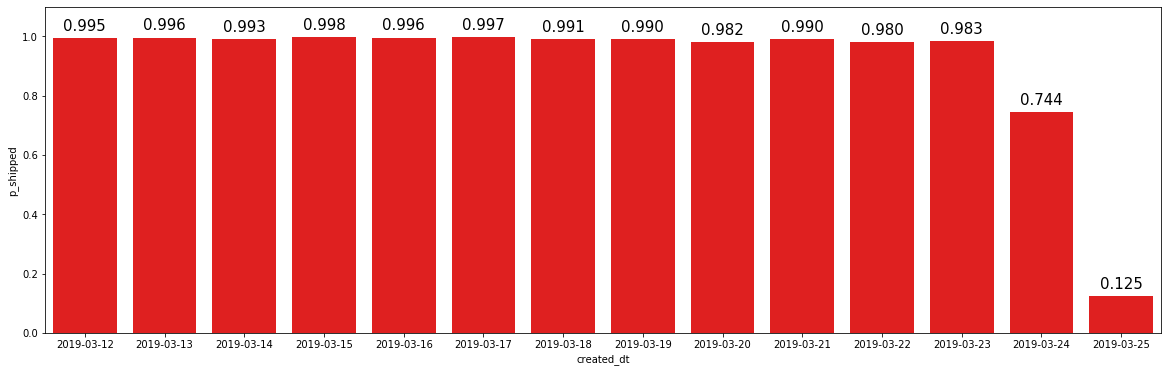

In [134]:
plt.figure(figsize=(20, 6))
g=sns.barplot(x="created_dt",  y="p_shipped", data=last_states.tail(14), color='red')

plt.ylim([0, 1.1])
for p in g.patches:
    g.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')
plt.show()

In [135]:
# This is a long time to remain partially shipped. Status update issues?
last_states[last_states.partially_shipped > 0].head(20)

state_recode,created_dt,cancelled,hold,open_order,ordered,partially_shipped,prepare_shipment,shipped,total,p_cancelled,p_hold,p_open_order,p_ordered,p_partially_shipped,p_prepared_shipment,p_shipped
360,2018-12-27,4.0,0.0,1.0,0.0,3.0,0.0,525.0,529.0,0.007561,0.0,0.001890,0.0,0.005671,0.0,0.992439
361,2018-12-28,4.0,0.0,1.0,0.0,2.0,0.0,572.0,575.0,0.006957,0.0,0.001739,0.0,0.003478,0.0,0.994783
362,2018-12-29,0.0,0.0,0.0,0.0,1.0,0.0,535.0,536.0,0.000000,0.0,0.000000,0.0,0.001866,0.0,0.998134
363,2018-12-30,5.0,0.0,0.0,0.0,2.0,0.0,500.0,502.0,0.009960,0.0,0.000000,0.0,0.003984,0.0,0.996016
365,2019-01-01,2.0,0.0,0.0,0.0,2.0,0.0,474.0,476.0,0.004202,0.0,0.000000,0.0,0.004202,0.0,0.995798
366,2019-01-02,3.0,0.0,0.0,0.0,2.0,0.0,799.0,801.0,0.003745,0.0,0.000000,0.0,0.002497,0.0,0.997503
367,2019-01-03,6.0,0.0,0.0,0.0,1.0,0.0,847.0,848.0,0.007075,0.0,0.000000,0.0,0.001179,0.0,0.998821
369,2019-01-05,2.0,0.0,0.0,0.0,1.0,0.0,829.0,830.0,0.002410,0.0,0.000000,0.0,0.001205,0.0,0.998795
370,2019-01-06,2.0,0.0,0.0,0.0,1.0,0.0,822.0,823.0,0.002430,0.0,0.000000,0.0,0.001215,0.0,0.998785
371,2019-01-07,7.0,0.0,0.0,0.0,1.0,0.0,929.0,930.0,0.007527,0.0,0.000000,0.0,0.001075,0.0,0.998925


## Registry Facts

one last thing I'm curious about!
What's the "lifetime" and "lifetime value" of a registry?

In [136]:
registry_dates = order_facts[['recipient_registry_id', 'created_dt']]\
    .groupby('recipient_registry_id')\
    .agg(['min', 'max'])\
    
registry_totals = order_facts[['recipient_registry_id', 'subtotal', 'baby_box']]\
    .groupby('recipient_registry_id')\
    .agg(['count', 'sum'])

registry_facts = registry_dates.join(registry_totals).reset_index()
registry_facts.tail(40)

registry_facts.columns = [('recipient_registry_id'), ('first_order'), ('last_order'), ('n_orders'), ('value'), ('del'), ('baby_boxes')]
registry_facts['cohort'] = pd.to_datetime(registry_facts.first_order.dt.to_period('M').astype(str)).dt.strftime('%Y-%m-%d')
registry_facts['lifetime'] = (registry_facts.last_order - registry_facts.first_order).apply(lambda x: x.days)
registry_facts = registry_facts.drop('del', axis=1)
registry_facts.head(20)

,recipient_registry_id,first_order,last_order,n_orders,value,baby_boxes,cohort,lifetime
0,0.0,2019-01-08,2019-01-08,1,59.99,0,2019-01-01,0
1,2.0,2018-07-31,2018-07-31,1,0.00,1,2018-07-01,0
2,8.0,2018-02-25,2018-02-25,1,0.00,0,2018-02-01,0
3,1138.0,2019-03-05,2019-03-05,1,49.99,0,2019-03-01,0
4,1256.0,2018-11-29,2018-11-29,1,25.00,0,2018-11-01,0
5,1263.0,2019-03-06,2019-03-06,1,69.99,0,2019-03-01,0
6,1349.0,2019-03-11,2019-03-11,1,65.00,0,2019-03-01,0
7,1655.0,2019-03-04,2019-03-04,1,79.99,0,2019-03-01,0
8,1899.0,2019-03-11,2019-03-11,1,44.99,0,2019-03-01,0
9,1903.0,2018-12-04,2019-03-25,5,538.96,0,2018-12-01,111


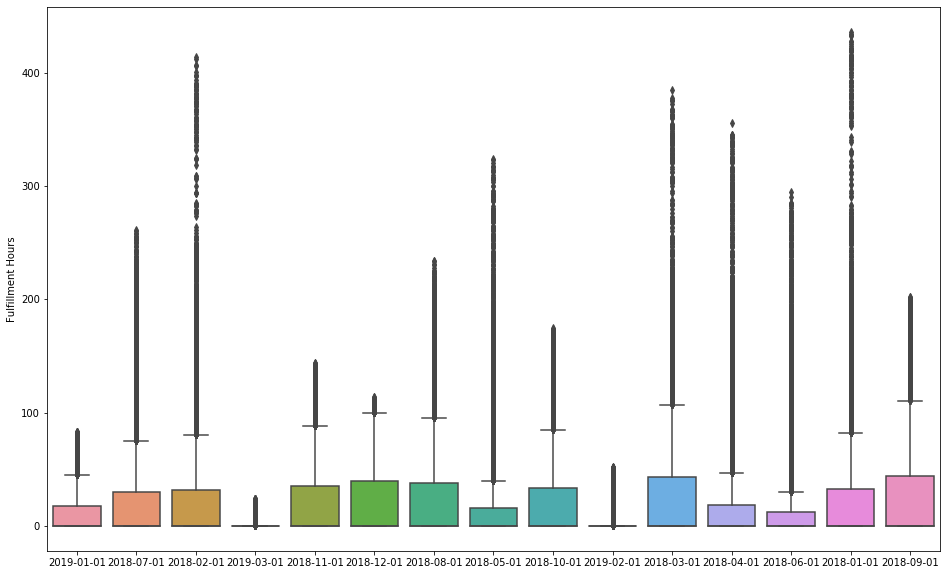

In [137]:
# Really, really long tails fulfillment hours
plt.figure(figsize=(16, 10))
# plt.ylim([0, 200])

ax = sns.boxplot(x="cohort"
                 , y="lifetime"
                 , data=registry_facts)
ax.set(xlabel=None)
ax.set(ylabel='Fulfillment Hours')
plt.show()

In [138]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.90)

registry_facts[['cohort', 'lifetime', 'n_orders', 'value']]\
    .groupby('cohort')\
    .agg([q25, 'median', q75, q90])

lifetime                      n_orders                value         \
                q25 median    q75    q90      q25 median q75 q90   q25 median   
cohort                                                                          
2018-01-01        0      0  33.00   96.0        1      1   2   5   0.0   0.00   
2018-02-01        0      0  32.00   98.0        0      0   2   4   0.0   0.00   
2018-03-01        0      0  43.00  112.0        0      0   2   4   0.0   0.00   
2018-04-01        0      0  19.00   97.0        0      0   1   3   0.0   0.00   
2018-05-01        0      0  16.00   93.0        0      0   1   3   0.0   0.00   
2018-06-01        0      0  12.00   92.0        0      1   1   4   0.0   0.00   
2018-07-01        0      0  30.00   93.0        1      1   2   5   0.0   0.00   
2018-08-01        0      0  38.00   95.0        1      1   2   5   0.0   0.00   
2018-09-01        0      0  44.00   99.6        1      1   3   5   0.0  11.99   
2018-10-01        0      0  34.00  100.0        1      1   2   5   0.0   0.00   
2018-11-01        0      0  35.25   92.0        1      1   2   5   0.0   0.00   
2018-12-01        0      0  40.00   78.0        0      1   2   5   0.0   0.00   
2019-01-01        0      0  18.00   52.0        1      1   2   4   0.0   0.00   
2019-02-01        0      0   0.00   27.0        1      1   1   3   0.0   0.00   
2019-03-01        0      0   0.00    4.0        1      1   1   2   0.0   0.00   

                               
                 q75      q90  
cohort                         
2018-01-01  122.3225  343.925  
2018-02-01   95.7850  300.000  
2018-03-01   89.9600  299.990  
2018-04-01   50.0000  243.372  
2018-05-01   50.0000  249.990  
2018-06-01   50.0000  249.990  
2018-07-01  100.0000  325.000  
2018-08-01  125.9500  359.855  
2018-09-01  144.9900  375.000  
2018-10-01  125.0000  364.860  
2018-11-01  109.9700  349.707  
2018-12-01  100.9900  374.422  
2019-01-01   79.9750  316.948  
2019-02-01   56.9900  252.980  
2019-03-01   39.9900  150.000

In [139]:
registry_dates = order_facts[np.logical_not(order_facts.baby_box)][['recipient_registry_id', 'created_dt']]\
    .groupby('recipient_registry_id')\
    .agg(['min', 'max'])\
    
registry_totals = order_facts[np.logical_not(order_facts.baby_box)][['recipient_registry_id', 'total']]\
    .groupby('recipient_registry_id')\
    .agg(['count', 'sum'])

registry_facts = registry_dates.join(registry_totals).reset_index()
registry_facts.head(20)

registry_facts.columns = [('recipient_registry_id'), ('first_order'), ('last_order'), ('n_orders'), ('value')]
registry_facts['cohort'] = pd.to_datetime(registry_facts.first_order.dt.to_period('M').astype(str)).dt.strftime('%Y-%m-%d')
registry_facts['lifetime'] = (registry_facts.last_order - registry_facts.first_order).apply(lambda x: x.days)

registry_facts.head(20)

,recipient_registry_id,first_order,last_order,n_orders,value,cohort,lifetime
0,0.0,2019-01-08,2019-01-08,1,65.27,2019-01-01,0
1,8.0,2018-02-25,2018-02-25,1,0.00,2018-02-01,0
2,1138.0,2019-03-05,2019-03-05,1,53.30,2019-03-01,0
3,1256.0,2018-11-29,2018-11-29,1,25.00,2018-11-01,0
4,1263.0,2019-03-06,2019-03-06,1,73.14,2019-03-01,0
5,1349.0,2019-03-11,2019-03-11,1,68.90,2019-03-01,0
6,1655.0,2019-03-04,2019-03-04,1,85.59,2019-03-01,0
7,1899.0,2019-03-11,2019-03-11,1,55.06,2019-03-01,0
8,1903.0,2018-12-04,2019-03-25,5,561.21,2018-12-01,111
9,6294.0,2018-08-22,2018-08-22,1,25.98,2018-08-01,0


In [140]:
registry_facts[['cohort', 'lifetime', 'n_orders', 'value']]\
    .groupby('cohort')\
    .agg([q25, 'median', q75, q90])

lifetime                n_orders                   value           \
                q25 median q75 q90      q25 median q75 q90      q25   median   
cohort                                                                         
2018-01-01        0      7  32  62        1      2   4   6  53.9500  132.110   
2018-02-01        0     10  37  69        1      2   4   6  54.4750  134.970   
2018-03-01        0     13  40  72        1      2   4   6  56.8950  142.630   
2018-04-01        0     12  40  73        1      2   4   7  55.8800  147.510   
2018-05-01        0     13  39  74        1      2   4   7  61.3650  151.700   
2018-06-01        0     10  40  74        1      2   4   6  59.9050  140.205   
2018-07-01        0     13  40  73        1      2   4   7  65.0000  157.930   
2018-08-01        0     11  39  72        1      2   4   6  63.9725  150.000   
2018-09-01        0     10  37  70        1      2   4   6  59.9900  144.540   
2018-10-01        0     10  36  87        1      2   4   6  59.9900  143.740   
2018-11-01        0      7  48  87        1      2   4   6  56.4800  138.040   
2018-12-01        0     24  53  77        1      3   5   8  87.6175  212.490   
2019-01-01        0     18  39  54        1      2   4   7  79.1950  196.820   
2019-02-01        0     10  25  35        1      2   4   6  65.8475  161.760   
2019-03-01        0      0   4  12        1      1   2   3  51.1050   99.940   

                               
                 q75      q90  
cohort                         
2018-01-01  303.8175  563.830  
2018-02-01  299.9900  567.642  
2018-03-01  318.7750  594.936  
2018-04-01  325.0000  595.574  
2018-05-01  336.0300  587.212  
2018-06-01  315.0400  572.136  
2018-07-01  346.7600  628.990  
2018-08-01  328.5225  587.270  
2018-09-01  309.9900  571.808  
2018-10-01  316.0950  576.262  
2018-11-01  318.7200  626.236  
2018-12-01  464.2700  777.370  
2019-01-01  415.3800  728.763  
2019-02-01  337.9475  599.943  
2019-03-01  200.0000  359.990

In [242]:
# What does registry usage look like over time?
#  Baby box only registry (looks like this used to be ok )
#  Baby box + only one merche order (current minimum reqs)
#  1 merch / gift card or fund order
#  Full Usage: 2 or more merch / gift card or fund orders, regardless of Baby Box status

tmp = order_facts[order_facts.state !='cancelled'][['recipient_registry_id', 'created_dt', 'subtotal', 'baby_box', 'n_merchandise', 'fund', 'gift_card']].copy()
tmp['baby_box'] = tmp['baby_box'].apply(lambda x: 1 if x > 0 else 0)
tmp['merchandise'] = tmp['n_merchandise'].apply(lambda x: 1 if x > 0 else 0)
tmp['fund'] = tmp['fund'].apply(lambda x: 1 if x > 0 else 0)
tmp['gift_card'] = tmp['gift_card'].apply(lambda x: 1 if x > 0 else 0)

registry_orders = tmp[['recipient_registry_id', 'baby_box', 'fund', 'gift_card', 'merchandise', 'subtotal']]\
    .groupby('recipient_registry_id')\
    .sum()\

def registry_usage(x):
    # Looks like a small handful of registries got 2
    if (x.baby_box >= 1) & (x.fund + x.gift_card + x.merchandise == 0):
        return 'baby_box_only'
    elif (x.baby_box >= 1) & (x.merchandise + x.gift_card + x.fund == 1):
        return 'baby_box_1_other_order'
    elif (x.merchandise + x.gift_card + x.fund == 1):
        # Single Order (Fund, Card or Merch), no baby box
        return 'single_order' 
    elif (x.merchandise + x.gift_card + x.fund > 1):
        # Multiple orders w/ or without baby box
        return 'multiple_order' 
    else:
        return 'other'
    
registry_orders['registry_usage'] = registry_orders.apply(registry_usage, axis=1)

registry_dates = tmp[['recipient_registry_id', 'created_dt']]\
    .groupby('recipient_registry_id')\
    .agg(['min', 'max'])
registry_dates.columns = ['first_order', 'last_order']

registry_facts = registry_orders.join(registry_dates).reset_index()

registry_facts['cohort_mt'] = pd.to_datetime(registry_facts.first_order.dt.to_period('M').astype(str)).dt.strftime('%Y-%m-%d')
registry_facts['cohort_wk'] = registry_facts['first_order'].dt.to_period('W').dt.start_time
registry_facts['lifetime'] = (registry_facts.last_order - registry_facts.first_order).apply(lambda x: x.days)

registry_facts.head()


,recipient_registry_id,baby_box,fund,gift_card,merchandise,subtotal,registry_usage,first_order,last_order,cohort_mt,cohort_wk,lifetime
0,0.0,0,0,0,1,59.99,single_order,2019-01-08,2019-01-08,2019-01-01,2019-01-07,0
1,1138.0,0,0,0,1,49.99,single_order,2019-03-05,2019-03-05,2019-03-01,2019-03-04,0
2,1256.0,0,0,1,0,25.00,single_order,2018-11-29,2018-11-29,2018-11-01,2018-11-26,0
3,1263.0,0,0,0,1,69.99,single_order,2019-03-06,2019-03-06,2019-03-01,2019-03-04,0
4,1349.0,0,0,0,1,65.00,single_order,2019-03-11,2019-03-11,2019-03-01,2019-03-11,0


In [243]:
registry_facts[['registry_usage', 'recipient_registry_id']].groupby('registry_usage').count()

,recipient_registry_id
registry_usage,
baby_box_1_other_order,20066
baby_box_only,156597
multiple_order,62361
single_order,18484


In [244]:
usage_summary = registry_facts[['cohort_wk', 'registry_usage', 'recipient_registry_id']]\
    .groupby(['cohort_wk','registry_usage'])\
    .count()\
    .rename(columns={'recipient_registry_id': 'n'})\
    .reset_index()\
    .pivot(index='cohort_wk', columns='registry_usage', values='n')

usage_summary['total'] = usage_summary.iloc[:,0] + usage_summary.iloc[:,1] + usage_summary.iloc[:,2] + usage_summary.iloc[:,3]

In [245]:
usage_summary.to_csv('data/registry_usage_totals.csv')

In [246]:
usage_summary.tail()

registry_usage,baby_box_1_other_order,baby_box_only,multiple_order,single_order,total
cohort_wk,,,,,
2019-02-25,203,3447,859,489,4998
2019-03-04,165,3816,804,718,5503
2019-03-11,145,3339,593,826,4903
2019-03-18,69,3357,306,1033,4765
2019-03-25,3,483,16,193,695


In [247]:
usage_summary_pr = usage_summary.copy()
usage_summary_pr.iloc[:,0] = usage_summary_pr.iloc[:,0].div(usage_summary.total)
usage_summary_pr.iloc[:,1] = usage_summary_pr.iloc[:,1].div(usage_summary.total)
usage_summary_pr.iloc[:,2] = usage_summary_pr.iloc[:,2].div(usage_summary.total)
usage_summary_pr.iloc[:,3] = usage_summary_pr.iloc[:,3].div(usage_summary.total)

usage_summary_pr.to_csv('data/registry_usage_summary.csv')